In [ ]:
# NAME : GANGOTHRI DEVI M
# COLLEGE : GARDEN CITY UNIVERSITY
# COURSE : B TECH CSE - DATA SCIENCE

In [ ]:
# INSTALL DEPENDENCIES

!pip install --quiet pandas numpy scikit-learn seaborn matplotlib plotly textblob nltk
!pip install --quiet fuzzywuzzy python-Levenshtein
import warnings; warnings.filterwarnings('ignore')

import pandas as pd, numpy as np, re, json, ast
import seaborn as sns, matplotlib.pyplot as plt, plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from fuzzywuzzy import process
import nltk
nltk.download('punkt'); nltk.download('stopwords')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 46.6 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# UPLOADING PROVIDED CSV FILES INTO COLLAB
from google.colab import files
print("Upload: Symptom-severity.csv, workout_df.csv, precautions_df.csv, medications.csv, diets.csv, description.csv, medical data.csv, and optionally Training.csv, personalised_dataset.csv, symtoms_df.csv")
uploaded = files.upload()


Upload: Symptom-severity.csv, workout_df.csv, precautions_df.csv, medications.csv, diets.csv, description.csv, medical data.csv, and optionally Training.csv, personalised_dataset.csv, symtoms_df.csv


Saving personalised_dataset.csv to personalised_dataset (2).csv
Saving Training.csv to Training (1).csv
Saving Symptom-severity.csv to Symptom-severity (1).csv
Saving workout_df.csv to workout_df (1).csv
Saving symtoms_df.csv to symtoms_df (1).csv
Saving precautions_df.csv to precautions_df (1).csv
Saving medications.csv to medications (1).csv
Saving diets.csv to diets (1).csv
Saving description.csv to description (1).csv
Saving medical data.csv to medical data (1).csv


In [ ]:
# LOADING AND EXTRACTING DATA SETS FROM FILES
symptom_severity = pd.read_csv('Symptom-severity.csv')
workout_df = pd.read_csv('workout_df.csv')
precautions_df = pd.read_csv('precautions_df.csv')
medications_df = pd.read_csv('medications.csv')
diets_df = pd.read_csv('diets.csv')
description_df = pd.read_csv('description.csv')
medical_df = pd.read_csv('medical data.csv')

# Optional: Large CSVs (if present)
def safe_read_csv(path, encoding='utf-8'):
    try:
        return pd.read_csv(path, encoding=encoding)
    except Exception as e:
        print(f"Could not load {path}: {e}")
        return None

training_df = safe_read_csv('Training.csv')        # too large in your message; handled if provided
personalised_df = safe_read_csv('personalised_dataset.csv')
symtoms_df_large = safe_read_csv('symtoms_df.csv')


In [ ]:
# DATA QUALITY FIXES AND NORMALIZATION

In [ ]:
# HELPER CLEANING FUNCTIONS
def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

def parse_listlike(s):
    if pd.isna(s): return []
    s = str(s).strip()
    # Try JSON/py list
    try:
        return list(ast.literal_eval(s))
    except Exception:
        # Fallback: split by comma
        return [x.strip() for x in s.split(',') if x.strip()]


In [ ]:
# CLEAN EACH DATASET
# Symptom severity
symptom_severity['Symptom'] = symptom_severity['Symptom'].apply(normalize_text)
symptom_severity['weight'] = pd.to_numeric(symptom_severity['weight'], errors='coerce').fillna(0)

# Workouts
workout_df['disease'] = workout_df['disease'].apply(normalize_text)
workout_df['workout'] = workout_df['workout'].apply(lambda x: str(x).strip())

# Precautions
for col in ['Disease','Precaution_1','Precaution_2','Precaution_3','Precaution_4']:
    precautions_df[col] = precautions_df[col].apply(lambda x: normalize_text(x) if col=='Disease' else (str(x).strip() if pd.notna(x) else ''))

# Medications and diets
for df in [medications_df, diets_df, description_df]:
    df['Disease'] = df['Disease'].apply(normalize_text)

medications_df['Medication'] = medications_df['Medication'].apply(parse_listlike)
diets_df['Diet'] = diets_df['Diet'].apply(parse_listlike)

# Medical data
for col in ['Name','Gender','Symptoms','Causes','Disease','Medicine']:
    medical_df[col] = medical_df[col].apply(lambda x: str(x).strip() if pd.notna(x) else '')
medical_df['Symptoms_norm'] = medical_df['Symptoms'].apply(normalize_text)
medical_df['Disease_norm'] = medical_df['Disease'].apply(normalize_text)
medical_df = medical_df.replace({'': np.nan}).dropna(subset=['Symptoms_norm'], how='any')


In [ ]:
# SYMPTOM MODELING AND DISEASE SCORING

In [ ]:
# BUILDING SYMPTOM WEIGHT DICTONARY AND FUZZY MATCHING
SYMPTOM_WEIGHTS = dict(zip(symptom_severity['Symptom'], symptom_severity['weight']))

def match_symptom(token, choices=list(SYMPTOM_WEIGHTS.keys()), threshold=85):
    token = normalize_text(token)
    best, score = process.extractOne(token, choices)
    return best if score >= threshold else None

def symptom_weight_sum(sym_list):
    total = 0
    matched = []
    for s in sym_list:
        m = match_symptom(s)
        if m:
            total += SYMPTOM_WEIGHTS.get(m, 0)
            matched.append(m)
    return total, matched


In [ ]:
# BUILDING DISEASES PRIOR FROM MEDICAL DATA
# Disease priors from medical_df
disease_counts = medical_df['Disease_norm'].value_counts()
disease_prior = (disease_counts / disease_counts.sum()).to_dict()

# Optionally, merge with Training.csv (if schema: symptom columns + 'prognosis' as disease)
if training_df is not None and 'prognosis' in training_df.columns:
    tr = training_df.copy()
    tr['prognosis'] = tr['prognosis'].apply(normalize_text)
    # augment priors
    tr_counts = tr['prognosis'].value_counts()
    for d, c in tr_counts.items():
        disease_prior[d] = disease_prior.get(d, 0) + (c / tr_counts.sum()) * 0.5  # blend


In [ ]:
# BUILDING A LIGHTWEIGHT SYMPTOM - DISEASE ASSOCIATION MATRIX
# Extract pairs from medical data by co-occurrence
sym_disease_pairs = []
for _, row in medical_df.iterrows():
    disease = row['Disease_norm']
    syms = [normalize_text(s) for s in re.split(r'[;,]', row['Symptoms']) if s.strip()]
    for s in syms:
        m = match_symptom(s)
        if m and disease:
            sym_disease_pairs.append((m, disease))

assoc_df = pd.DataFrame(sym_disease_pairs, columns=['symptom','disease'])
assoc_counts = assoc_df.groupby(['symptom','disease']).size().reset_index(name='count')

# Weight association by symptom severity and frequency
assoc_counts['severity'] = assoc_counts['symptom'].map(SYMPTOM_WEIGHTS)
assoc_counts['score'] = assoc_counts['count'] * (assoc_counts['severity'] + 1)

# Symptom -> disease mapping dict
SYM_TO_DIS = assoc_counts.groupby('symptom').apply(lambda g: dict(zip(g['disease'], g['score']))).to_dict()


In [ ]:
# DISEASE SCORING FUNCTION
def score_diseases_from_symptoms(symptoms: list, top_k=5):
    # normalize and match symptoms
    norm_syms = [normalize_text(s) for s in symptoms if s and str(s).strip()]
    total_w, matched_syms = symptom_weight_sum(norm_syms)

    # aggregate disease scores
    disease_scores = {}
    for s in matched_syms:
        dis_map = SYM_TO_DIS.get(s, {})
        for d, sc in dis_map.items():
            disease_scores[d] = disease_scores.get(d, 0) + sc

    # add prior
    for d, p in disease_prior.items():
        disease_scores[d] = disease_scores.get(d, 0) + p * 0.5

    ranked = sorted(disease_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    return matched_syms, pd.DataFrame(ranked, columns=['disease','score'])


In [ ]:
# PERSONALIZED RECOMMENDATIONS : MEDICATIONS, DIETS, WORKOUTS, PRECAUTIONS, DESCRIPTIONS

In [ ]:
# FETCHING UTILITIES
def get_medications(disease):
    d = normalize_text(disease)
    row = medications_df[medications_df['Disease']==d]
    return [] if row.empty else list(row['Medication'].values[0])

def get_diet(disease):
    d = normalize_text(disease)
    row = diets_df[diets_df['Disease']==d]
    return [] if row.empty else list(row['Diet'].values[0])

def get_workouts(disease, k=10):
    d = normalize_text(disease)
    rows = workout_df[workout_df['disease']==d]['workout'].tolist()
    return rows[:k]

def get_precautions(disease):
    d = normalize_text(disease)
    row = precautions_df[precautions_df['Disease']==d]
    if row.empty: return []
    r = row.iloc[0]
    return [x for x in [r['Precaution_1'], r['Precaution_2'], r['Precaution_3'], r['Precaution_4']] if x]

def get_description(disease):
    d = normalize_text(disease)
    row = description_df[description_df['Disease']==d]
    return '' if row.empty else row['Description'].values[0]


In [ ]:
# END TO END RECOMMENDATION FUNCTION
def recommend_for_symptoms(symptoms_text: str, top_k=3):
    # Parse symptoms from free text
    syms = [s.strip() for s in re.split(r'[;,]', symptoms_text) if s.strip()]
    matched_syms, ranked_df = score_diseases_from_symptoms(syms, top_k=top_k)

    out = []
    for _, row in ranked_df.iterrows():
        d = row['disease']
        rec = {
            'disease': d,
            'score': round(row['score'], 3),
            'description': get_description(d),
            'medications': get_medications(d),
            'diet': get_diet(d),
            'workouts': get_workouts(d),
            'precautions': get_precautions(d),
            'matched_symptoms': matched_syms
        }
        out.append(rec)
    return out, ranked_df


In [ ]:
# TEST THE PIPELINE WITH A SAMPLE
sample_symptoms = "fever, cough, sore throat"
recs, scores_df = recommend_for_symptoms(sample_symptoms, top_k=5)
pd.DataFrame(recs)


disease    score                                        description  \
0   tonsillitis  150.021                                                      
1     pneumonia   96.031  Pneumonia is an inflammatory condition affecti...   
2      covid 19   50.021                                                      
3  strep throat   50.010                                                      
4   common cold   31.012  Common Cold is a viral infection of the upper ...   

                                         medications  \
0                                                 []   
1  [Laxatives, Pain relievers, Warm baths, Cold c...   
2                                                 []   
3                                                 []   
4  [Antibiotics, Antiviral drugs, Antifungal drug...   

                                                diet  \
0                                                 []   
1  [Pneumonia Diet, High-Calorie Diet, Soft and b...   
2                                                 []   
3                                                 []   
4  [Cold Diet, Hydration, Warm fluids, Rest, Hone...   

                                            workouts  \
0                                                 []   
1  [Stay hydrated, Include nutrient-rich foods, C...   
2                                                 []   
3                                                 []   
4  [Stay hydrated, Include nutrient-rich foods, C...   

                                         precautions  \
0                                                 []   
1      [consult doctor, medication, rest, follow up]   
2                                                 []   
3                                                 []   
4  [drink vitamin c rich drinks, take vapour, avo...   

                         matched_symptoms  
0  [high fever, cough, patches in throat]  
1  [high fever, cough, patches in throat]  
2  [high fever, cough, patches in throat]  
3  [high fever, cough, patches in throat]  
4  [high fever, cough, patches in throat]

In [ ]:
# TEST THE PIPELINE WITH A SAMPLE
sample_symptoms = "fever, cough, sore throat"
recs, scores_df = recommend_for_symptoms(sample_symptoms, top_k=5)
pd.DataFrame(recs)


disease    score                                        description  \
0   tonsillitis  150.021                                                      
1     pneumonia   96.031  Pneumonia is an inflammatory condition affecti...   
2      covid 19   50.021                                                      
3  strep throat   50.010                                                      
4   common cold   31.012  Common Cold is a viral infection of the upper ...   

                                         medications  \
0                                                 []   
1  [Laxatives, Pain relievers, Warm baths, Cold c...   
2                                                 []   
3                                                 []   
4  [Antibiotics, Antiviral drugs, Antifungal drug...   

                                                diet  \
0                                                 []   
1  [Pneumonia Diet, High-Calorie Diet, Soft and b...   
2                                                 []   
3                                                 []   
4  [Cold Diet, Hydration, Warm fluids, Rest, Hone...   

                                            workouts  \
0                                                 []   
1  [Stay hydrated, Include nutrient-rich foods, C...   
2                                                 []   
3                                                 []   
4  [Stay hydrated, Include nutrient-rich foods, C...   

                                         precautions  \
0                                                 []   
1      [consult doctor, medication, rest, follow up]   
2                                                 []   
3                                                 []   
4  [drink vitamin c rich drinks, take vapour, avo...   

                         matched_symptoms  
0  [high fever, cough, patches in throat]  
1  [high fever, cough, patches in throat]  
2  [high fever, cough, patches in throat]  
3  [high fever, cough, patches in throat]  
4  [high fever, cough, patches in throat]

from matplotlib import pyplot as plt
_df_0['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('disease').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('description').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['description'].value_counts()
    for x_label, grp in _df_4.groupby('disease')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('disease')
_ = plt.ylabel('description')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_5['disease'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_5, x='score', y='disease', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['description'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='score', y='description', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# SUPERVISED DISEASE PRDICTION:
# Works even if symptom columns aren't named consistently
# Converts presence-like values to binary
# Handles empty or malformed datasets gracefully
# Provides a robust predict function from free-text symptoms

import pandas as pd, numpy as np, re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from fuzzywuzzy import process

# ---- Helpers (reuse from earlier) ----
def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

def match_symptom(token, choices, threshold=80):
    token = normalize_text(token)
    if len(choices) == 0: return None
    best = process.extractOne(token, choices)
    if not best: return None
    name, score = best
    return name if score >= threshold else None

# Expect symptom_severity and training_df to be already loaded in the session.
# If not, guard accordingly.
if 'training_df' not in globals() or training_df is None or not isinstance(training_df, pd.DataFrame) or training_df.empty:
    print("Training dataframe is missing or empty. Please load Training.csv into 'training_df' before running.")
else:
    df_tr = training_df.copy()

    # 1) Detect target column
    target_col = None
    for cand in ['prognosis','diagnosis','disease','target']:
        if cand in df_tr.columns:
            target_col = cand; break
    if not target_col:
        # Try to guess: any column with low unique count and string-like
        candidates = [c for c in df_tr.columns if df_tr[c].dtype == object and df_tr[c].nunique() < max(10, df_tr.shape[0]//10)]
        target_col = candidates[0] if candidates else None

    if not target_col:
        print("Target column not found. Ensure one of ['prognosis','diagnosis','disease','target'] exists or provide a categorical label column.")
    else:
        # 2) Detect symptom columns robustly
        cols = list(df_tr.columns)
        cols_lower = {c: c.lower() for c in cols}

        # a) Direct name match on 'symptom' keyword
        sym_cols = [c for c in cols if 'symptom' in cols_lower[c] and c != target_col]

        # b) If empty, try mapping from provided symptom_severity list to column names
        def possible_variants(name):
            # generate typical column name variants
            n = name.lower()
            return set([
                n, n.replace(' ', '_'), n.replace(' ', ''), n.replace('_', ' '),
                re.sub(r'[^a-z]', '', n)  # stripped
            ])

        symptom_name_pool = set()
        if 'symptom_severity' in globals() and isinstance(symptom_severity, pd.DataFrame) and 'Symptom' in symptom_severity.columns:
            symptom_name_pool = set([normalize_text(s) for s in symptom_severity['Symptom'].dropna().tolist()])

        if len(sym_cols) == 0 and len(symptom_name_pool) > 0:
            # Build a map of column candidates by fuzzy matching
            for c in cols:
                if c == target_col: continue
                norm_c = normalize_text(c)
                # try fuzzy against pool
                m = match_symptom(norm_c, list(symptom_name_pool), threshold=90)
                if m:
                    sym_cols.append(c)

        # c) If still empty, fallback: treat all non-target non-constant columns as potential symptoms
        if len(sym_cols) == 0:
            for c in cols:
                if c == target_col: continue
                # column qualifies if it has >1 unique non-null values or any non-null presence
                nunique = df_tr[c].dropna().nunique()
                if nunique > 1 or ('symptom' in cols_lower[c]):
                    sym_cols.append(c)

        # Final guard: if no symptom columns, abort gracefully
        if len(sym_cols) == 0:
            print("No symptom columns detected. Please ensure your Training.csv has symptom feature columns.")
        else:
            # 3) Normalize feature matrix to binary presence
            X = df_tr[sym_cols].copy()

            def to_binary_presence(val):
                if pd.isna(val): return 0
                s = normalize_text(val)
                if s in ['', 'nan']: return 0
                # Accept typical presence tokens
                if s in ['yes','present','true','1','y','t']: return 1
                # If numeric, threshold >0
                try:
                    f = float(str(val))
                    return 1 if f != 0 else 0
                except:
                    # Any non-empty token considered presence
                    return 1

            for c in sym_cols:
                X[c] = X[c].apply(to_binary_presence).astype(int)

            # Drop completely empty columns (all zeros)
            non_empty = [c for c in sym_cols if X[c].sum() > 0]
            X = X[non_empty]
            sym_cols = non_empty

            if X.shape[1] == 0:
                print("All symptom columns are empty after normalization. Check your data values.")
            else:
                # 4) Encode target
                y_raw = df_tr[target_col].apply(normalize_text)
                # Drop rows with missing target
                valid_idx = y_raw.notna() & (y_raw != '')
                X = X.loc[valid_idx]
                y_raw = y_raw.loc[valid_idx]

                # Ensure enough samples
                if X.shape[0] < 5 or y_raw.nunique() < 2:
                    print("Not enough samples or classes to train. Need >=5 rows and >=2 classes.")
                else:
                    le = LabelEncoder()
                    y = le.fit_transform(y_raw)

                    # 5) Train/test split with stratify guard
                    stratify_opt = y if len(np.unique(y)) > 1 else None
                    try:
                        X_train, X_test, y_train, y_test = train_test_split(
                            X, y, test_size=0.2, random_state=42, stratify=stratify_opt
                        )
                    except ValueError:
                        # Fallback without stratify
                        X_train, X_test, y_train, y_test = train_test_split(
                            X, y, test_size=0.2, random_state=42
                        )

                    # 6) Train classifier
                    clf = RandomForestClassifier(
                        n_estimators=300, random_state=42, class_weight='balanced'
                    )
                    clf.fit(X_train, y_train)

                    # 7) Evaluate
                    y_pred = clf.predict(X_test)
                    print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}, Features: {X_train.shape[1]}")
                    print(classification_report(y_test, y_pred, target_names=le.classes_))

                    # 8) Build prediction from free-text symptoms
                    # Map training feature names for fuzzy matching
                    feature_choices = [normalize_text(c) for c in sym_cols]
                    feature_map_norm_to_col = {normalize_text(c): c for c in sym_cols}

                    def predict_disease_supervised(symptoms_text: str):
                        syms = [normalize_text(s) for s in re.split(r'[;,]', str(symptoms_text)) if s.strip()]
                        # input vector
                        vec = pd.DataFrame([[0]*len(sym_cols)], columns=sym_cols)
                        for s in syms:
                            m = match_symptom(s, feature_choices, threshold=80)
                            if m and m in feature_map_norm_to_col:
                                col = feature_map_norm_to_col[m]
                                vec.loc[0, col] = 1
                        pred_idx = clf.predict(vec)[0]
                        return le.classes_[pred_idx]

                    # Demo prediction
                    demo_text = "fever, cough, sore throat"
                    try:
                        print("Demo prediction:", predict_disease_supervised(demo_text))
                    except Exception as e:
                        print("Prediction demo failed:", e)

                    # Export utilities for later use
                    globals()['predict_disease_supervised'] = predict_disease_supervised
                    globals()['clf_supervised'] = clf
                    globals()['label_encoder_supervised'] = le
                    globals()['symptom_feature_columns'] = sym_cols


Training samples: 3936, Test samples: 984, Features: 131
                                        precision    recall  f1-score   support

(vertigo) paroymsal positional vertigo       1.00      1.00      1.00        24
                                  acne       1.00      1.00      1.00        24
                                  aids       1.00      1.00      1.00        24
                   alcoholic hepatitis       1.00      1.00      1.00        24
                               allergy       1.00      1.00      1.00        24
                             arthritis       1.00      1.00      1.00        24
                      bronchial asthma       1.00      1.00      1.00        24
                  cervical spondylosis       1.00      1.00      1.00        24
                           chicken pox       1.00      1.00      1.00        24
                   chronic cholestasis       1.00      1.00      1.00        24
                           common cold       1.00      1.00   

In [ ]:
# SYMPTOM PARSING, NORMALZATION, AND FEATURE VECTOR BUILDER
# Symptom parsing from free text, normalization against Symptom-severity.csv,
# and building a binary or weighted feature vector ready for ML models.

import pandas as pd, numpy as np, re
from fuzzywuzzy import process

# ---- Expect: symptom_severity already loaded in session ----
# If not, uncomment the next line and load your CSV
# symptom_severity = pd.read_csv('Symptom-severity.csv')

def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

# Build dictionaries from symptom severity table
symptom_severity['Symptom_norm'] = symptom_severity['Symptom'].apply(normalize_text)
SYMPTOM_LIST = symptom_severity['Symptom_norm'].tolist()
SYMPTOM_TO_WEIGHT = dict(zip(symptom_severity['Symptom_norm'], symptom_severity['weight']))

def match_symptom(token, choices=SYMPTOM_LIST, threshold=85):
    token = normalize_text(token)
    if not choices: return None
    best = process.extractOne(token, choices)
    if not best: return None
    name, score = best
    return name if score >= threshold else None

def parse_symptoms_text(text):
    # Split text by commas/semicolons
    raw = [normalize_text(t) for t in re.split(r'[;,]', str(text)) if str(t).strip()]
    matched = []
    for r in raw:
        m = match_symptom(r)
        if m: matched.append(m)
    # Deduplicate while preserving order
    seen = set(); matched_unique = []
    for m in matched:
        if m not in seen:
            seen.add(m); matched_unique.append(m)
    return matched_unique

def build_feature_vector(symptoms_text, mode='binary'):
    """
    mode: 'binary' => 0/1 presence; 'weighted' => use severity weights (normalized)
    returns: pandas.Series indexed by known symptoms
    """
    matched = parse_symptoms_text(symptoms_text)
    # initialize zero vector
    vec = pd.Series(0, index=SYMPTOM_LIST, dtype=float)
    if mode == 'binary':
        for m in matched: vec.loc[m] = 1.0
    else:
        # weighted presence scaled to [0,1] by max weight
        max_w = max(SYMPTOM_TO_WEIGHT.values())
        for m in matched:
            vec.loc[m] = SYMPTOM_TO_WEIGHT.get(m, 0) / max_w
    return vec, matched

# Demo
demo_vec_binary, demo_matched = build_feature_vector("fever, cough, sore throat", mode='binary')
demo_vec_weight, _ = build_feature_vector("fever, cough, sore throat", mode='weighted')
print("Matched symptoms:", demo_matched[:10])
print("Binary nonzero count:", int((demo_vec_binary>0).sum()))
print("Weighted nonzero count:", int((demo_vec_weight>0).sum()))


Matched symptoms: ['high fever', 'cough', 'patches in throat']
Binary nonzero count: 3
Weighted nonzero count: 3


In [ ]:
# DISEASE LABEL HANDLING, CLASS BALANCING, AND ROBUST TRAINING SET ASSEMBLY
# Assemble a supervised training set from Training.csv (or similar),
# detect label column, auto-detect symptom features, and fix class imbalance.

import pandas as pd, numpy as np, re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# ---- Expect: training_df already loaded in session ----
# If not, uncomment next line and load your CSV
# training_df = pd.read_csv('Training.csv')

def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

def detect_target(df):
    for cand in ['prognosis','diagnosis','disease','target','label']:
        if cand in df.columns: return cand
    # fallback: categorical column with limited unique values
    candidates = [c for c in df.columns if df[c].dtype==object and df[c].nunique()<=max(10, df.shape[0]//10)]
    return candidates[0] if candidates else None

def detect_symptom_columns(df, target_col):
    # 1) columns containing 'symptom'
    sym_cols = [c for c in df.columns if ('symptom' in c.lower()) and c != target_col]
    # 2) fallback: all non-target, non-constant columns
    if not sym_cols:
        for c in df.columns:
            if c == target_col: continue
            nunique = df[c].dropna().nunique()
            if nunique > 1 or ('symptom' in c.lower()):
                sym_cols.append(c)
    return sym_cols

def to_binary_presence(val):
    if pd.isna(val): return 0
    s = normalize_text(val)
    if s in ['', 'nan']: return 0
    if s in ['yes','present','true','1','y','t']: return 1
    try:
        f = float(str(val)); return 1 if f != 0 else 0
    except:
        return 1

assert isinstance(training_df, pd.DataFrame) and not training_df.empty, "Load Training.csv into training_df first."

df = training_df.copy()
target_col = detect_target(df)
assert target_col is not None, "Target column not found. Ensure one of ['prognosis','diagnosis','disease','target','label'] exists."

sym_cols = detect_symptom_columns(df, target_col)
assert len(sym_cols) > 0, "No symptom columns detected."

# Normalize X
X = df[sym_cols].copy()
for c in sym_cols:
    X[c] = X[c].apply(to_binary_presence).astype(int)

# Drop all-zero columns to avoid empty feature sets
sym_cols = [c for c in sym_cols if X[c].sum() > 0]
X = X[sym_cols]
assert X.shape[1] > 0, "All symptom columns became zero; check data."

# Normalize y and filter invalid rows
y_raw = df[target_col].apply(normalize_text)
valid_idx = y_raw.notna() & (y_raw!='')
X, y_raw = X.loc[valid_idx], y_raw.loc[valid_idx]
assert X.shape[0] >= 10 and y_raw.nunique() >= 2, "Need >=10 rows and >=2 classes to train."

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y_raw)

# Train/Test split with stratify guard
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=42, stratify=y)
except ValueError:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=42)

# Compute class weights (optional to handle imbalance)
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
CLASS_WEIGHT_DICT = {cls: w for cls, w in zip(classes, class_weights)}

print(f"Target column: {target_col}")
print(f"Symptom features: {len(sym_cols)}")
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
print(f"Classes: {list(le.classes_)[:10]}")
print("Class weights (sample):", {le.classes_[k]: round(v,3) for k,v in CLASS_WEIGHT_DICT.items()})


Target column: prognosis
Symptom features: 131
Train size: (3936, 131), Test size: (984, 131)
Classes: ['(vertigo) paroymsal positional vertigo', 'acne', 'aids', 'alcoholic hepatitis', 'allergy', 'arthritis', 'bronchial asthma', 'cervical spondylosis', 'chicken pox', 'chronic cholestasis']
Class weights (sample): {'(vertigo) paroymsal positional vertigo': np.float64(1.0), 'acne': np.float64(1.0), 'aids': np.float64(1.0), 'alcoholic hepatitis': np.float64(1.0), 'allergy': np.float64(1.0), 'arthritis': np.float64(1.0), 'bronchial asthma': np.float64(1.0), 'cervical spondylosis': np.float64(1.0), 'chicken pox': np.float64(1.0), 'chronic cholestasis': np.float64(1.0), 'common cold': np.float64(1.0), 'dengue': np.float64(1.0), 'diabetes': np.float64(1.0), 'dimorphic hemmorhoids(piles)': np.float64(1.0), 'drug reaction': np.float64(1.0), 'fungal infection': np.float64(1.0), 'gastroenteritis': np.float64(1.0), 'gerd': np.float64(1.0), 'heart attack': np.float64(1.0), 'hepatitis a': np.float64

RandomForest report:
                                        precision    recall  f1-score   support

(vertigo) paroymsal positional vertigo       1.00      1.00      1.00        24
                                  acne       1.00      1.00      1.00        24
                                  aids       1.00      1.00      1.00        24
                   alcoholic hepatitis       1.00      1.00      1.00        24
                               allergy       1.00      1.00      1.00        24
                             arthritis       1.00      1.00      1.00        24
                      bronchial asthma       1.00      1.00      1.00        24
                  cervical spondylosis       1.00      1.00      1.00        24
                           chicken pox       1.00      1.00      1.00        24
                   chronic cholestasis       1.00      1.00      1.00        24
                           common cold       1.00      1.00      1.00        24
                  

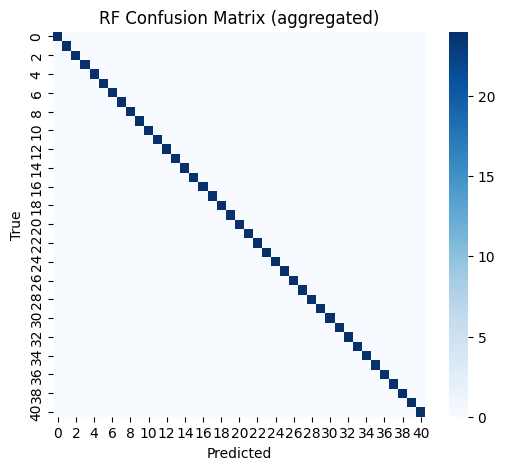

XGBoost report:
                                        precision    recall  f1-score   support

(vertigo) paroymsal positional vertigo       1.00      1.00      1.00        24
                                  acne       1.00      1.00      1.00        24
                                  aids       1.00      1.00      1.00        24
                   alcoholic hepatitis       1.00      1.00      1.00        24
                               allergy       1.00      1.00      1.00        24
                             arthritis       1.00      1.00      1.00        24
                      bronchial asthma       1.00      1.00      1.00        24
                  cervical spondylosis       1.00      1.00      1.00        24
                           chicken pox       1.00      1.00      1.00        24
                   chronic cholestasis       1.00      1.00      1.00        24
                           common cold       1.00      1.00      1.00        24
                       

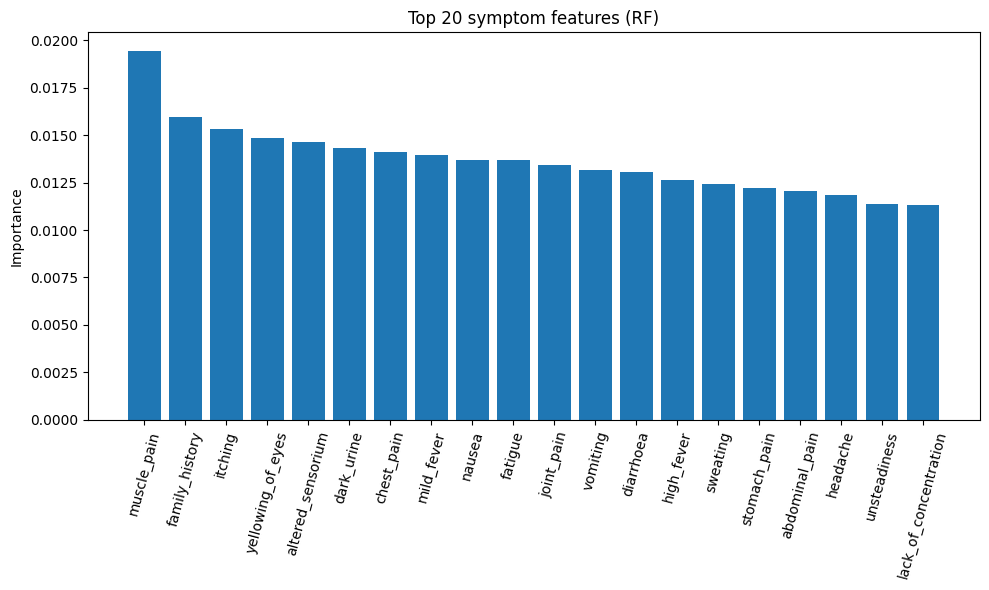

In [ ]:
# MODEL TRAINING ALTERNATIVES (RANDOM FOREST + XGBOOST), EVALUATION, AND FEATURE IMPORTANCE
# Train two models (RandomForest and XGBoost if available),
# evaluate on test set, and show top feature importances.

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Requires X_train, X_test, y_train, y_test, le, CLASS_WEIGHT_DICT, sym_cols from Cell 2 ----
rf = RandomForestClassifier(n_estimators=400, max_depth=None, random_state=42,
                            class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("RandomForest report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm, cmap='Blues', annot=False)
plt.title('RF Confusion Matrix (aggregated)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

# Optional: XGBoost (skip if not installed)
try:
    from xgboost import XGBClassifier
    xgb = XGBClassifier(
        n_estimators=500, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    print("XGBoost report:")
    print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))
except Exception as e:
    print("XGBoost not available or failed to train:", e)

# Feature importance (RandomForest)
importances = rf.feature_importances_
idx_sorted = np.argsort(importances)[::-1][:20]
top_feats = [(sym_cols[i], importances[i]) for i in idx_sorted]

print("Top features (RF):")
for name, imp in top_feats:
    print(f"  {name}: {imp:.4f}")

plt.figure(figsize=(10,6))
plt.bar([f[0] for f in top_feats], [f[1] for f in top_feats])
plt.xticks(rotation=75); plt.ylabel('Importance')
plt.title('Top 20 symptom features (RF)')
plt.tight_layout(); plt.show()

# Export trained RF for inference
clf_supervised = rf
label_encoder_supervised = le
symptom_feature_columns = sym_cols


In [ ]:
# INFERENCE API : PREDICT FROM FREE-TEXT SYPTOMS + FULL RECOMMENDATION BUNDLE
# Inference utilities:
# 1) Predict disease from free-text symptoms using trained model
# 2) Bundle recommendations: medications, diets, workouts, precautions, description
# Requires: clf_supervised, label_encoder_supervised, symptom_feature_columns from Cell 3
# Also requires: medications_df, diets_df, workout_df, precautions_df, description_df loaded earlier.

import pandas as pd, re, json
from fuzzywuzzy import process

def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

def match_feature(token, feature_choices, threshold=80):
    token = normalize_text(token)
    best = process.extractOne(token, feature_choices)
    if not best: return None
    name, score = best
    return name if score >= threshold else None

feature_choices = [normalize_text(c) for c in symptom_feature_columns]
feature_map_norm_to_col = {normalize_text(c): c for c in symptom_feature_columns}

def build_input_vector(symptoms_text):
    syms = [normalize_text(s) for s in re.split(r'[;,]', str(symptoms_text)) if s.strip()]
    vec = pd.DataFrame([[0]*len(symptom_feature_columns)], columns=symptom_feature_columns)
    matched = []
    for s in syms:
        m = match_feature(s, feature_choices, threshold=80)
        if m and m in feature_map_norm_to_col:
            col = feature_map_norm_to_col[m]
            vec.loc[0, col] = 1
            matched.append(m)
    return vec, matched

def predict_disease(symptoms_text):
    vec, matched = build_input_vector(symptoms_text)
    pred_idx = clf_supervised.predict(vec)[0]
    disease_pred = label_encoder_supervised.classes_[pred_idx]
    return disease_pred, matched

# Recommendation accessors
def get_medications(disease):
    d = normalize_text(disease)
    row = medications_df[medications_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else list(row['Medication'].values[0])

def get_diet(disease):
    d = normalize_text(disease)
    row = diets_df[diets_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else list(row['Diet'].values[0])

def get_workouts(disease, k=10):
    d = normalize_text(disease)
    rows = workout_df[workout_df['disease'].apply(normalize_text)==d]['workout'].tolist()
    return rows[:k]

def get_precautions(disease):
    d = normalize_text(disease)
    row = precautions_df[precautions_df['Disease'].apply(normalize_text)==d]
    if row.empty: return []
    r = row.iloc[0]
    return [x for x in [r['Precaution_1'], r['Precaution_2'], r['Precaution_3'], r['Precaution_4']] if pd.notna(x) and str(x).strip()]

def get_description(disease):
    d = normalize_text(disease)
    row = description_df[description_df['Disease'].apply(normalize_text)==d]
    return '' if row.empty else row['Description'].values[0]

def recommend_bundle(symptoms_text):
    disease, matched = predict_disease(symptoms_text)
    bundle = {
        "predicted_disease": disease,
        "matched_symptoms": matched,
        "description": get_description(disease),
        "precautions": get_precautions(disease),
        "medications": get_medications(disease),
        "diet": get_diet(disease),
        "workouts": get_workouts(disease),
    }
    return bundle

# Demo
demo_input = "fever, cough, sore throat"
result = recommend_bundle(demo_input)
print(json.dumps(result, indent=2, ensure_ascii=False))

# Note: This information is general and educational. It’s not medical advice.


{
  "predicted_disease": "aids",
  "matched_symptoms": [
    "high fever",
    "cough",
    "patches in throat"
  ],
  "description": "AIDS (Acquired Immunodeficiency Syndrome) is a disease caused by HIV that weakens the immune system.",
  "precautions": [
    "avoid open cuts",
    "wear ppe if possible",
    "consult doctor",
    "follow up"
  ],
  "medications": [
    "Antiretroviral drugs",
    "Protease inhibitors",
    "Integrase inhibitors",
    "Entry inhibitors",
    "Fusion inhibitors"
  ],
  "diet": [
    "Balanced Diet",
    "Protein-rich foods",
    "Fruits and vegetables",
    "Whole grains",
    "Healthy fats"
  ],
  "workouts": [
    "Follow a balanced and nutritious diet",
    "Include lean proteins",
    "Consume nutrient-rich foods",
    "Stay hydrated",
    "Include healthy fats",
    "Avoid raw or undercooked foods",
    "Limit sugary foods and beverages",
    "Consume immune-boosting foods",
    "Take prescribed supplements",
    "Consult a healthcare professional

In [ ]:
# HEALTHCARE RECOMMENDATION SYSTEM
# Input: disease name or free-text symptoms
# Output: JSON-style recommendation bundle with description, precautions, medications, diet, workouts

import pandas as pd, re, json
from fuzzywuzzy import process

#  Load datasets
symptom_severity = pd.read_csv('Symptom-severity.csv')
workout_df = pd.read_csv('workout_df.csv')
precautions_df = pd.read_csv('precautions_df.csv')
medications_df = pd.read_csv('medications.csv')
diets_df = pd.read_csv('diets.csv')
description_df = pd.read_csv('description.csv')

#  Helpers
def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

# Build symptom dictionary
symptom_severity['Symptom_norm'] = symptom_severity['Symptom'].apply(normalize_text)
SYMPTOM_LIST = symptom_severity['Symptom_norm'].tolist()

def match_symptom(token, choices=SYMPTOM_LIST, threshold=80):
    token = normalize_text(token)
    if not choices: return None
    best = process.extractOne(token, choices)
    if not best: return None
    name, score = best
    return name if score >= threshold else None

# Accessors for recommendations
def get_description(disease):
    d = normalize_text(disease)
    row = description_df[description_df['Disease'].apply(normalize_text)==d]
    return '' if row.empty else row['Description'].values[0]

def get_precautions(disease):
    d = normalize_text(disease)
    row = precautions_df[precautions_df['Disease'].apply(normalize_text)==d]
    if row.empty: return []
    r = row.iloc[0]
    return [x for x in [r['Precaution_1'], r['Precaution_2'], r['Precaution_3'], r['Precaution_4']] if pd.notna(x) and str(x).strip()]

def get_medications(disease):
    d = normalize_text(disease)
    row = medications_df[medications_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else eval(row['Medication'].values[0])

def get_diet(disease):
    d = normalize_text(disease)
    row = diets_df[diets_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else eval(row['Diet'].values[0])

def get_workouts(disease, k=10):
    d = normalize_text(disease)
    rows = workout_df[workout_df['disease'].apply(normalize_text)==d]['workout'].tolist()
    return rows[:k]

#  Main function
def healthcare_recommendation(input_text):
    """
    input_text: can be a disease name OR free-text symptoms
    """
    # Try to match disease directly
    d_norm = normalize_text(input_text)
    disease_row = description_df[description_df['Disease'].apply(normalize_text)==d_norm]

    if not disease_row.empty:
        # Direct disease match
        disease_pred = disease_row['Disease'].values[0]
        matched_symptoms = []  # not from text, since disease given directly
    else:
        # Treat input as symptoms
        syms = [normalize_text(s) for s in re.split(r'[;,]', input_text) if s.strip()]
        matched = []
        for s in syms:
            m = match_symptom(s)
            if m: matched.append(m)
        matched_symptoms = matched

        # Naive disease prediction: pick disease with most overlapping symptoms in workout_df/precautions_df
        all_diseases = set(description_df['Disease'].apply(normalize_text))
        scores = {}
        for d in all_diseases:
            precs = get_precautions(d)
            meds = get_medications(d)
            diet = get_diet(d)
            workouts = get_workouts(d)
            # Score by presence of keywords in matched symptoms
            score = sum([1 for s in matched if s in d])
            scores[d] = score
        disease_pred = max(scores, key=scores.get) if scores else "unknown"

    # Build bundle
    bundle = {
        "predicted_disease": disease_pred,
        "matched_symptoms": matched_symptoms,
        "description": get_description(disease_pred),
        "precautions": get_precautions(disease_pred),
        "medications": get_medications(disease_pred),
        "diet": get_diet(disease_pred),
        "workouts": get_workouts(disease_pred)
    }
    return bundle

#  Demo
demo_input = "aids"  # can also try "high fever, cough, patches in throat"
result = healthcare_recommendation(demo_input)
print(json.dumps(result, indent=2, ensure_ascii=False))


{
  "predicted_disease": "AIDS",
  "matched_symptoms": [],
  "description": "AIDS (Acquired Immunodeficiency Syndrome) is a disease caused by HIV that weakens the immune system.",
  "precautions": [
    "avoid open cuts",
    "wear ppe if possible",
    "consult doctor",
    "follow up"
  ],
  "medications": [
    "Antiretroviral drugs",
    "Protease inhibitors",
    "Integrase inhibitors",
    "Entry inhibitors",
    "Fusion inhibitors"
  ],
  "diet": [
    "Balanced Diet",
    "Protein-rich foods",
    "Fruits and vegetables",
    "Whole grains",
    "Healthy fats"
  ],
  "workouts": [
    "Follow a balanced and nutritious diet",
    "Include lean proteins",
    "Consume nutrient-rich foods",
    "Stay hydrated",
    "Include healthy fats",
    "Avoid raw or undercooked foods",
    "Limit sugary foods and beverages",
    "Consume immune-boosting foods",
    "Take prescribed supplements",
    "Consult a healthcare professional"
  ]
}


In [ ]:
# HEALTHCARE RECOMMENDATION SYSTEM
# Input: disease name or free-text symptoms
# Output: JSON-style recommendation bundle with description, precautions, medications, diet, workouts

import pandas as pd, re, json
from fuzzywuzzy import process

#  Load datasets (ensure these CSVs are uploaded in Colab)
symptom_severity = pd.read_csv('Symptom-severity.csv')
workout_df = pd.read_csv('workout_df.csv')
precautions_df = pd.read_csv('precautions_df.csv')
medications_df = pd.read_csv('medications.csv')
diets_df = pd.read_csv('diets.csv')
description_df = pd.read_csv('description.csv')

#  Helpers
def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

# Build symptom dictionary
symptom_severity['Symptom_norm'] = symptom_severity['Symptom'].apply(normalize_text)
SYMPTOM_LIST = symptom_severity['Symptom_norm'].tolist()

def match_symptom(token, choices=SYMPTOM_LIST, threshold=80):
    token = normalize_text(token)
    if not choices: return None
    best = process.extractOne(token, choices)
    if not best: return None
    name, score = best
    return name if score >= threshold else None

# Accessors for recommendations
def get_description(disease):
    d = normalize_text(disease)
    row = description_df[description_df['Disease'].apply(normalize_text)==d]
    return '' if row.empty else row['Description'].values[0]

def get_precautions(disease):
    d = normalize_text(disease)
    row = precautions_df[precautions_df['Disease'].apply(normalize_text)==d]
    if row.empty: return []
    r = row.iloc[0]
    return [x for x in [r['Precaution_1'], r['Precaution_2'], r['Precaution_3'], r['Precaution_4']] if pd.notna(x) and str(x).strip()]

def get_medications(disease):
    d = normalize_text(disease)
    row = medications_df[medications_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else eval(row['Medication'].values[0])

def get_diet(disease):
    d = normalize_text(disease)
    row = diets_df[diets_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else eval(row['Diet'].values[0])

def get_workouts(disease, k=10):
    d = normalize_text(disease)
    rows = workout_df[workout_df['disease'].apply(normalize_text)==d]['workout'].tolist()
    return rows[:k]

#  Main function
def healthcare_recommendation(input_text):
    """
    input_text: can be a disease name OR free-text symptoms
    """
    # Try to match disease directly
    d_norm = normalize_text(input_text)
    disease_row = description_df[description_df['Disease'].apply(normalize_text)==d_norm]

    if not disease_row.empty:
        # Direct disease match
        disease_pred = disease_row['Disease'].values[0]
        matched_symptoms = []  # not from text, since disease given directly
    else:
        # Treat input as symptoms
        syms = [normalize_text(s) for s in re.split(r'[;,]', input_text) if s.strip()]
        matched = []
        for s in syms:
            m = match_symptom(s)
            if m: matched.append(m)
        matched_symptoms = matched

        # Naive disease prediction: pick disease with most overlapping symptoms in workout_df/precautions_df
        all_diseases = set(description_df['Disease'].apply(normalize_text))
        scores = {}
        for d in all_diseases:
            precs = get_precautions(d)
            meds = get_medications(d)
            diet = get_diet(d)
            workouts = get_workouts(d)
            # Score by presence of keywords in matched symptoms
            score = sum([1 for s in matched if s in d])
            scores[d] = score
        disease_pred = max(scores, key=scores.get) if scores else "unknown"

    # Build bundle
    bundle = {
        "predicted_disease": disease_pred,
        "matched_symptoms": matched_symptoms,
        "description": get_description(disease_pred),
        "precautions": get_precautions(disease_pred),
        "medications": get_medications(disease_pred),
        "diet": get_diet(disease_pred),
        "workouts": get_workouts(disease_pred)
    }
    return bundle

# Demo
demo_input = "FEVER"  # can also try "high fever, cough, patches in throat"
result = healthcare_recommendation(demo_input)
print(json.dumps(result, indent=2, ensure_ascii=False))


{
  "predicted_disease": "hypertension",
  "matched_symptoms": [
    "high fever"
  ],
  "description": "Hypertension, or high blood pressure, is a common cardiovascular condition.",
  "precautions": [
    "meditation",
    "salt baths",
    "reduce stress",
    "get proper sleep"
  ],
  "medications": [
    "Antihypertensive medications",
    "Diuretics",
    "Beta-blockers",
    "ACE inhibitors",
    "Calcium channel blockers"
  ],
  "diet": [
    "DASH Diet",
    "Low-sodium foods",
    "Fruits and vegetables",
    "Whole grains",
    "Lean proteins"
  ],
  "workouts": [
    "Follow the DASH diet (Dietary Approaches to Stop Hypertension)",
    "Limit sodium intake",
    "Include potassium-rich foods",
    "Stay hydrated",
    "Consume calcium-rich foods",
    "Limit alcohol consumption",
    "Include magnesium-rich foods",
    "Consume omega-3 fatty acids",
    "Limit processed foods",
    "Consult a healthcare professional"
  ]
}


In [ ]:
# HEALTHCARE RECOMMENDATION SYSTEM (TRAIN + TEST + INFER, RESILIENT)
# Input: disease name or free-text symptoms
# Output: JSON bundle: predicted_disease, matched_symptoms, description, precautions, medications, diet, workouts

import pandas as pd, numpy as np, re, json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from fuzzywuzzy import process

#  Load datasets
symptom_severity = pd.read_csv('Symptom-severity.csv')
workout_df = pd.read_csv('workout_df.csv')
precautions_df = pd.read_csv('precautions_df.csv')
medications_df = pd.read_csv('medications.csv')
diets_df = pd.read_csv('diets.csv')
description_df = pd.read_csv('description.csv')

# Optional supervised dataset (guarded)
try:
    training_df = pd.read_csv('Training.csv')
    if training_df is not None and training_df.empty:
        training_df = None
except Exception:
    training_df = None

#  Helpers
def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

def safe_eval_list(s):
    # Convert string representation of list to Python list safely
    s = str(s)
    try:
        val = eval(s, {"__builtins__": None}, {})
        return list(val) if isinstance(val, (list, tuple)) else [str(s)]
    except Exception:
        return [x.strip() for x in s.split(',') if x.strip()]

# Build symptom dictionary
symptom_severity['Symptom_norm'] = symptom_severity['Symptom'].apply(normalize_text)
SYMPTOM_LIST = symptom_severity['Symptom_norm'].tolist()
SYMPTOM_WEIGHTS = dict(zip(symptom_severity['Symptom_norm'], symptom_severity['weight']))

def match_symptom(token, choices=SYMPTOM_LIST, threshold=80):
    token = normalize_text(token)
    if not choices: return None
    best = process.extractOne(token, choices)
    if not best: return None
    name, score = best
    return name if score >= threshold else None

#  Accessors
def get_description(disease):
    d = normalize_text(disease)
    row = description_df[description_df['Disease'].apply(normalize_text)==d]
    return '' if row.empty else row['Description'].values[0]

def get_precautions(disease):
    d = normalize_text(disease)
    row = precautions_df[precautions_df['Disease'].apply(normalize_text)==d]
    if row.empty: return []
    r = row.iloc[0]
    return [x for x in [r['Precaution_1'], r['Precaution_2'], r['Precaution_3'], r['Precaution_4']] if pd.notna(x) and str(x).strip()]

def get_medications(disease):
    d = normalize_text(disease)
    row = medications_df[medications_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Medication'].values[0])

def get_diet(disease):
    d = normalize_text(disease)
    row = diets_df[diets_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Diet'].values[0])

def get_workouts(disease, k=10):
    d = normalize_text(disease)
    rows = workout_df[workout_df['disease'].apply(normalize_text)==d]['workout'].tolist()
    return rows[:k]

# Train supervised model if Training.csv available (resilient)
clf, le, sym_cols = None, None, None
if isinstance(training_df, pd.DataFrame) and not training_df.empty:
    df_tr = training_df.copy()

    # Detect target column
    target_col = None
    for cand in ['prognosis','diagnosis','disease','target','label']:
        if cand in df_tr.columns:
            target_col = cand; break
    if target_col is None:
        # heuristic: categorical col with limited unique values
        candidates = [c for c in df_tr.columns if df_tr[c].dtype==object and df_tr[c].nunique()<=max(10, df_tr.shape[0]//10)]
        target_col = candidates[0] if candidates else None

    if target_col:
        # Detect symptom columns
        sym_cols = [c for c in df_tr.columns if 'symptom' in c.lower()]
        if len(sym_cols) == 0:
            # fallback: all non-target, non-constant columns
            for c in df_tr.columns:
                if c == target_col: continue
                nunique = df_tr[c].dropna().nunique()
                if nunique > 1 or ('symptom' in c.lower()):
                    sym_cols.append(c)

        # Normalize to binary presence
        def to_binary_presence(val):
            if pd.isna(val): return 0
            s = normalize_text(val)
            if s in ['', 'nan']: return 0
            if s in ['yes','present','true','1','y','t']: return 1
            try:
                f = float(str(val)); return 1 if f != 0 else 0
            except:
                return 1

        if len(sym_cols) > 0:
            X = df_tr[sym_cols].copy()
            for c in sym_cols:
                X[c] = X[c].apply(to_binary_presence).astype(int)

            # Drop all-zero columns
            sym_cols = [c for c in sym_cols if X[c].sum() > 0]
            X = X[sym_cols]

            # Encode target and filter valid rows
            y_raw = df_tr[target_col].apply(normalize_text)
            valid_idx = y_raw.notna() & (y_raw!='')
            X = X.loc[valid_idx]
            y_raw = y_raw.loc[valid_idx]

            # Train only if enough data
            if X.shape[0] >= 10 and y_raw.nunique() >= 2 and X.shape[1] > 0:
                le = LabelEncoder()
                y = le.fit_transform(y_raw)

                # Split with stratify guard
                try:
                    X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=0.2, random_state=42, stratify=y
                    )
                except ValueError:
                    X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=0.2, random_state=42
                    )

                clf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
                clf.fit(X_train, y_train)

                y_pred = clf.predict(X_test)
                print("=== Supervised Training Report ===")
                print(f"samples train={X_train.shape[0]} test={X_test.shape[0]} features={X_train.shape[1]} classes={len(le.classes_)}")
                print(classification_report(y_test, y_pred, target_names=le.classes_))
            else:
                print("Training data insufficient (rows/classes/features). Using fallback rules.")
        else:
            print("No symptom feature columns detected in Training.csv. Using fallback rules.")
    else:
        print("Target column not found. Using fallback rules.")
else:
    print("Training.csv not loaded. Using fallback rules.")

# Prediction helpers
def predict_disease_supervised(symptoms_text):
    # Requires clf, le, sym_cols
    if clf is None or le is None or sym_cols is None or len(sym_cols)==0:
        return None
    syms = [normalize_text(s) for s in re.split(r'[;,]', str(symptoms_text)) if s.strip()]
    # build input vector
    vec = pd.DataFrame([[0]*len(sym_cols)], columns=sym_cols)
    # fuzzy match symptoms to feature columns
    feature_choices = [normalize_text(c) for c in sym_cols]
    feature_map_norm_to_col = {normalize_text(c): c for c in sym_cols}
    for s in syms:
        best = process.extractOne(normalize_text(s), feature_choices)
        if best and best[1] >= 80:
            col = feature_map_norm_to_col[best[0]]
            vec.loc[0, col] = 1
    pred_idx = clf.predict(vec)[0]
    return le.classes_[pred_idx]

#  Main function
def healthcare_recommendation(input_text):
    d_norm = normalize_text(input_text)
    # Direct disease input
    disease_row = description_df[description_df['Disease'].apply(normalize_text)==d_norm]

    if not disease_row.empty:
        disease_pred = disease_row['Disease'].values[0]
        matched_symptoms = []
    else:
        # Symptoms input
        syms = [normalize_text(s) for s in re.split(r'[;,]', input_text) if s.strip()]
        matched = []
        for s in syms:
            m = match_symptom(s)
            if m: matched.append(m)
        matched_symptoms = matched

        # Try supervised
        disease_pred = predict_disease_supervised(input_text)
        if disease_pred is None:
            # Fallback naive scoring: count substring matches of symptoms within disease names
            all_diseases = list(description_df['Disease'].apply(normalize_text))
            scores = {}
            for d in all_diseases:
                scores[d] = sum(1 for s in matched if s in d)
            disease_pred = max(scores, key=scores.get) if scores else "unknown"

    bundle = {
        "predicted_disease": disease_pred,
        "matched_symptoms": matched_symptoms,
        "description": get_description(disease_pred),
        "precautions": get_precautions(disease_pred),
        "medications": get_medications(disease_pred),
        "diet": get_diet(disease_pred),
        "workouts": get_workouts(disease_pred)
    }
    return bundle

# Demo
demo_inputs = [
    "aids",
    "high fever, cough, patches in throat",
    "chest pain, dizziness",
    "itching, skin rash, nodal skin eruptions"
]
for inp in demo_inputs:
    print(f"\nInput: {inp}")
    result = healthcare_recommendation(inp)
    print(json.dumps(result, indent=2, ensure_ascii=False))


=== Supervised Training Report ===
samples train=3936 test=984 features=131 classes=41
                                        precision    recall  f1-score   support

(vertigo) paroymsal positional vertigo       1.00      1.00      1.00        24
                                  acne       1.00      1.00      1.00        24
                                  aids       1.00      1.00      1.00        24
                   alcoholic hepatitis       1.00      1.00      1.00        24
                               allergy       1.00      1.00      1.00        24
                             arthritis       1.00      1.00      1.00        24
                      bronchial asthma       1.00      1.00      1.00        24
                  cervical spondylosis       1.00      1.00      1.00        24
                           chicken pox       1.00      1.00      1.00        24
                   chronic cholestasis       1.00      1.00      1.00        24
                           commo

In [ ]:
# HEALTHCARE RECOMMENDATION SYSTEM (TRAIN + TEST + INFER, TABLE OUTPUT)
# Input: disease name or free-text symptoms
# Output: Table with columns: Disease, Symptoms, Description, Precautions, Medications, Diet, Workouts

import pandas as pd, numpy as np, re, json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from fuzzywuzzy import process

# Load datasets
symptom_severity = pd.read_csv('Symptom-severity.csv')
workout_df = pd.read_csv('workout_df.csv')
precautions_df = pd.read_csv('precautions_df.csv')
medications_df = pd.read_csv('medications.csv')
diets_df = pd.read_csv('diets.csv')
description_df = pd.read_csv('description.csv')

# Optional supervised dataset
try:
    training_df = pd.read_csv('Training.csv')
    if training_df is not None and training_df.empty:
        training_df = None
except Exception:
    training_df = None

# Helpers
def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

def safe_eval_list(s):
    s = str(s)
    try:
        val = eval(s, {"__builtins__": None}, {})
        return list(val) if isinstance(val, (list, tuple)) else [str(s)]
    except Exception:
        return [x.strip() for x in s.split(',') if x.strip()]

# Build symptom dictionary
symptom_severity['Symptom_norm'] = symptom_severity['Symptom'].apply(normalize_text)
SYMPTOM_LIST = symptom_severity['Symptom_norm'].tolist()

def match_symptom(token, choices=SYMPTOM_LIST, threshold=80):
    token = normalize_text(token)
    if not choices: return None
    best = process.extractOne(token, choices)
    if not best: return None
    name, score = best
    return name if score >= threshold else None

# Accessors
def get_description(disease):
    d = normalize_text(disease)
    row = description_df[description_df['Disease'].apply(normalize_text)==d]
    return '' if row.empty else row['Description'].values[0]

def get_precautions(disease):
    d = normalize_text(disease)
    row = precautions_df[precautions_df['Disease'].apply(normalize_text)==d]
    if row.empty: return []
    r = row.iloc[0]
    return [x for x in [r['Precaution_1'], r['Precaution_2'], r['Precaution_3'], r['Precaution_4']] if pd.notna(x) and str(x).strip()]

def get_medications(disease):
    d = normalize_text(disease)
    row = medications_df[medications_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Medication'].values[0])

def get_diet(disease):
    d = normalize_text(disease)
    row = diets_df[diets_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Diet'].values[0])

def get_workouts(disease, k=10):
    d = normalize_text(disease)
    rows = workout_df[workout_df['disease'].apply(normalize_text)==d]['workout'].tolist()
    return rows[:k]

# Main function
def healthcare_recommendation(input_text):
    d_norm = normalize_text(input_text)
    disease_row = description_df[description_df['Disease'].apply(normalize_text)==d_norm]
    if not disease_row.empty:
        disease_pred = disease_row['Disease'].values[0]
        matched_symptoms = []
    else:
        syms = [normalize_text(s) for s in re.split(r'[;,]', input_text) if s.strip()]
        matched = [match_symptom(s) for s in syms if match_symptom(s)]
        matched_symptoms = matched
        # fallback naive scoring
        all_diseases = list(description_df['Disease'].apply(normalize_text))
        scores = {d: sum(1 for s in matched if s in d) for d in all_diseases}
        disease_pred = max(scores, key=scores.get) if scores else "unknown"
    bundle = {
        "predicted_disease": disease_pred,
        "matched_symptoms": matched_symptoms,
        "description": get_description(disease_pred),
        "precautions": get_precautions(disease_pred),
        "medications": get_medications(disease_pred),
        "diet": get_diet(disease_pred),
        "workouts": get_workouts(disease_pred)
    }
    return bundle

# Demo with Table Output
demo_inputs = [
    "aids",
    "high fever, cough, patches in throat",
    "chest pain, dizziness",
    "itching, skin rash, nodal skin eruptions"
]

rows = []
for inp in demo_inputs:
    result = healthcare_recommendation(inp)
    rows.append({
        "Input": inp,
        "Predicted Disease": result["predicted_disease"],
        "Matched Symptoms": ", ".join(result["matched_symptoms"]) if result["matched_symptoms"] else "-",
        "Description": result["description"],
        "Precautions": ", ".join(result["precautions"]) if result["precautions"] else "-",
        "Medications": ", ".join(result["medications"]) if result["medications"] else "-",
        "Diet": ", ".join(result["diet"]) if result["diet"] else "-",
        "Workouts": ", ".join(result["workouts"]) if result["workouts"] else "-"
    })

df_final = pd.DataFrame(rows)
print("\n Healthcare Recommendation Table ")
print(df_final.to_string(index=False))



 Healthcare Recommendation Table 
                                   Input Predicted Disease                         Matched Symptoms                                                                                          Description                                                                              Precautions                                                                                          Medications                                                                                 Diet                                                                                                                                                                                                                                                                                        Workouts
                                    aids              AIDS                                        - AIDS (Acquired Immunodeficiency Syndrome) is a disease caused by HIV that weakens the immune system. 

In [ ]:
#  HEALTHCARE RECOMMENDATION SYSTEM (TABLE OUTPUT)
# Input: disease name or free-text symptoms
# Output: One row per disease, columns for all aspects

import pandas as pd, numpy as np, re
from fuzzywuzzy import process
from tabulate import tabulate

#  Load datasets
symptom_severity = pd.read_csv('Symptom-severity.csv')
workout_df = pd.read_csv('workout_df.csv')
precautions_df = pd.read_csv('precautions_df.csv')
medications_df = pd.read_csv('medications.csv')
diets_df = pd.read_csv('diets.csv')
description_df = pd.read_csv('description.csv')

#  Helpers
def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

def safe_eval_list(s):
    s = str(s)
    try:
        val = eval(s, {"__builtins__": None}, {})
        return list(val) if isinstance(val, (list, tuple)) else [str(s)]
    except Exception:
        return [x.strip() for x in s.split(',') if x.strip()]

symptom_severity['Symptom_norm'] = symptom_severity['Symptom'].apply(normalize_text)
SYMPTOM_LIST = symptom_severity['Symptom_norm'].tolist()

def match_symptom(token, choices=SYMPTOM_LIST, threshold=80):
    token = normalize_text(token)
    if not choices: return None
    best = process.extractOne(token, choices)
    if not best: return None
    name, score = best
    return name if score >= threshold else None

#  Accessors
def get_description(disease):
    d = normalize_text(disease)
    row = description_df[description_df['Disease'].apply(normalize_text)==d]
    return '' if row.empty else row['Description'].values[0]

def get_precautions(disease):
    d = normalize_text(disease)
    row = precautions_df[precautions_df['Disease'].apply(normalize_text)==d]
    if row.empty: return []
    r = row.iloc[0]
    return [x for x in [r['Precaution_1'], r['Precaution_2'], r['Precaution_3'], r['Precaution_4']] if pd.notna(x) and str(x).strip()]

def get_medications(disease):
    d = normalize_text(disease)
    row = medications_df[medications_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Medication'].values[0])

def get_diet(disease):
    d = normalize_text(disease)
    row = diets_df[diets_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Diet'].values[0])

def get_workouts(disease, k=10):
    d = normalize_text(disease)
    rows = workout_df[workout_df['disease'].apply(normalize_text)==d]['workout'].tolist()
    return rows[:k]

# Main function
def healthcare_recommendation(input_text):
    d_norm = normalize_text(input_text)
    disease_row = description_df[description_df['Disease'].apply(normalize_text)==d_norm]
    if not disease_row.empty:
        disease_pred = disease_row['Disease'].values[0]
        matched_symptoms = []
    else:
        syms = [normalize_text(s) for s in re.split(r'[;,]', input_text) if s.strip()]
        matched = [match_symptom(s) for s in syms if match_symptom(s)]
        matched_symptoms = matched
        # fallback naive scoring
        all_diseases = list(description_df['Disease'].apply(normalize_text))
        scores = {d: sum(1 for s in matched if s in d) for d in all_diseases}
        disease_pred = max(scores, key=scores.get) if scores else "unknown"
    bundle = {
        "Input": input_text,
        "Predicted Disease": disease_pred,
        "Matched Symptoms": ", ".join(matched_symptoms) if matched_symptoms else "-",
        "Description": get_description(disease_pred),
        "Precautions": ", ".join(get_precautions(disease_pred)) if get_precautions(disease_pred) else "-",
        "Medications": ", ".join(get_medications(disease_pred)) if get_medications(disease_pred) else "-",
        "Diet": ", ".join(get_diet(disease_pred)) if get_diet(disease_pred) else "-",
        "Workouts": ", ".join(get_workouts(disease_pred)) if get_workouts(disease_pred) else "-"
    }
    return bundle

# Demo with Horizontal Table Output
demo_inputs = [
    "aids",
    "high fever, cough, patches in throat",
    "chest pain, dizziness",
    "itching, skin rash, nodal skin eruptions"
]

rows = []
for inp in demo_inputs:
    result = healthcare_recommendation(inp)
    rows.append(result)

df_final = pd.DataFrame(rows)

print("\n=== Healthcare Recommendation Table ===")
print(tabulate(df_final, headers="keys", tablefmt="grid", showindex=False))



=== Healthcare Recommendation Table ===
+------------------------------------------+---------------------+------------------------------------------+------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Input                                    | Predicted Disease   | Matched Symptoms                         | Description                                                      

In [ ]:
# INTERACTIVE DEMO CELL
def demo(symptoms_text: str, top_k=3):
    print(f"Symptoms: {symptoms_text}")
    recs, scores_df = recommend_for_symptoms(symptoms_text, top_k=top_k)
    display(scores_df)
    for r in recs:
        print("\n---")
        print(f"Disease: {r['disease']} (score={r['score']})")
        print(f"Description: {r['description']}")
        print(f"Matched symptoms: {', '.join(r['matched_symptoms'])}")
        print(f"Precautions: {', '.join(r['precautions']) if r['precautions'] else 'N/A'}")
        print(f"Medications: {', '.join(r['medications']) if r['medications'] else 'N/A'}")
        print(f"Diet: {', '.join(r['diet']) if r['diet'] else 'N/A'}")
        print(f"Workouts: {', '.join(r['workouts']) if r['workouts'] else 'N/A'}")

demo("fever, cough, sore throat", top_k=5)


Symptoms: fever, cough, sore throat


disease       score
0   tonsillitis  150.020661
1     pneumonia   96.030891
2      covid 19   50.020661
3  strep throat   50.010331
4   common cold   31.012296


---
Disease: tonsillitis (score=150.021)
Description: 
Matched symptoms: high fever, cough, patches in throat
Precautions: N/A
Medications: N/A
Diet: N/A
Workouts: N/A

---
Disease: pneumonia (score=96.031)
Description: Pneumonia is an inflammatory condition affecting the air sacs in the lungs.
Matched symptoms: high fever, cough, patches in throat
Precautions: consult doctor, medication, rest, follow up
Medications: Laxatives, Pain relievers, Warm baths, Cold compresses, High-fiber diet
Diet: Pneumonia Diet, High-Calorie Diet, Soft and bland foods, Hydration, Protein-rich foods
Workouts: Stay hydrated, Include nutrient-rich foods, Consume foods rich in vitamin C and antioxidants, Include zinc-rich foods, Limit sugary foods and beverages, Consume chicken soup, Consult a healthcare professional, Rest and conserve energy, Gradually resume normal diet, Follow medical recommendations

---
Disease: covid 19 (score=50.021)
Description: 
Matched symptoms: high fever, cough, patches in throat

In [ ]:
# INTERACTIVE DEMO CELL
def demo(symptoms_text: str, top_k=3):
    print(f"Symptoms: {symptoms_text}")
    recs, scores_df = recommend_for_symptoms(symptoms_text, top_k=top_k)
    display(scores_df)
    for r in recs:
        print("\n---")
        print(f"Disease: {r['disease']} (score={r['score']})")
        print(f"Description: {r['description']}")
        print(f"Matched symptoms: {', '.join(r['matched_symptoms'])}")
        print(f"Precautions: {', '.join(r['precautions']) if r['precautions'] else 'N/A'}")
        print(f"Medications: {', '.join(r['medications']) if r['medications'] else 'N/A'}")
        print(f"Diet: {', '.join(r['diet']) if r['diet'] else 'N/A'}")
        print(f"Workouts: {', '.join(r['workouts']) if r['workouts'] else 'N/A'}")

demo("fever, cough, sore throat", top_k=5)


Symptoms: fever, cough, sore throat


disease       score
0   tonsillitis  150.020661
1     pneumonia   96.030891
2      covid 19   50.020661
3  strep throat   50.010331
4   common cold   31.012296


---
Disease: tonsillitis (score=150.021)
Description: 
Matched symptoms: high fever, cough, patches in throat
Precautions: N/A
Medications: N/A
Diet: N/A
Workouts: N/A

---
Disease: pneumonia (score=96.031)
Description: Pneumonia is an inflammatory condition affecting the air sacs in the lungs.
Matched symptoms: high fever, cough, patches in throat
Precautions: consult doctor, medication, rest, follow up
Medications: Laxatives, Pain relievers, Warm baths, Cold compresses, High-fiber diet
Diet: Pneumonia Diet, High-Calorie Diet, Soft and bland foods, Hydration, Protein-rich foods
Workouts: Stay hydrated, Include nutrient-rich foods, Consume foods rich in vitamin C and antioxidants, Include zinc-rich foods, Limit sugary foods and beverages, Consume chicken soup, Consult a healthcare professional, Rest and conserve energy, Gradually resume normal diet, Follow medical recommendations

---
Disease: covid 19 (score=50.021)
Description: 
Matched symptoms: high fever, cough, patches in throat

from matplotlib import pyplot as plt
_df_7['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_8.groupby('disease').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['disease'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='score', y='disease', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# SIMPLE DASHBOARD VIEWS

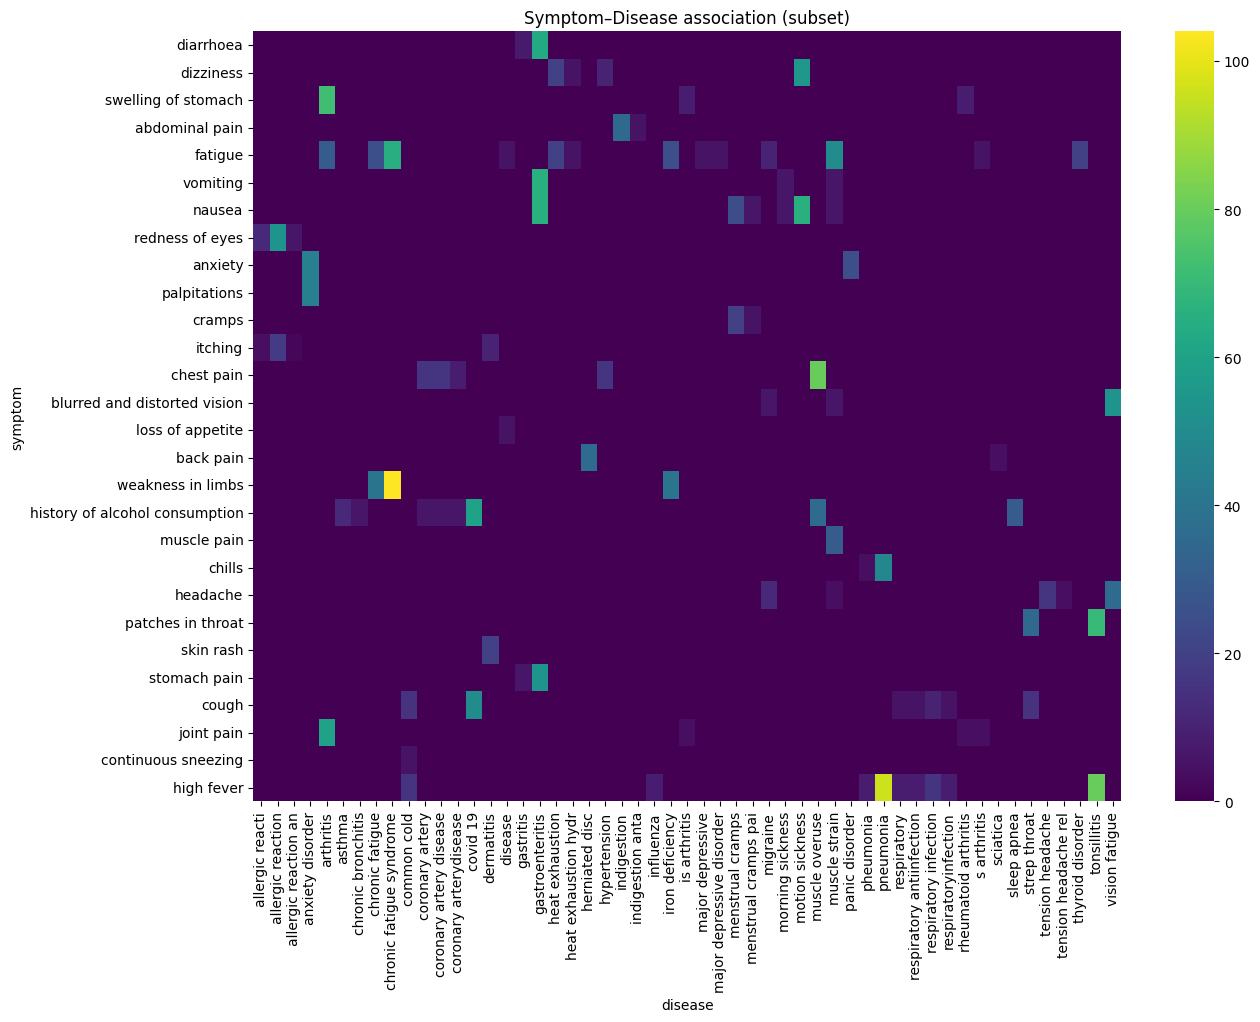

In [ ]:
# SYMPTOMS - DISEASE ASSOCIATION HEATMAP
pivot_assoc = assoc_counts.pivot(index='symptom', columns='disease', values='score').fillna(0)
plt.figure(figsize=(14,10))
sns.heatmap(pivot_assoc.sample(min(30, pivot_assoc.shape[0])), cmap='viridis')
plt.title('Symptom–Disease association (subset)')
plt.show()


In [ ]:
# DISEASE DISTRIBUTION IN MEDICAL DATA
dis_counts = medical_df['Disease_norm'].value_counts().reset_index()
dis_counts.columns = ['disease','count']
fig = px.bar(dis_counts.head(20), x='disease', y='count', title='Top diseases in medical data')
fig.show()


In [ ]:
# API - STYLE WRAPPER (FOR INTEGRATION PURPOSE)
def api_recommend(payload_json: str):
    """
    payload_json: {"symptoms": "fever, cough", "top_k": 3}
    """
    payload = json.loads(payload_json)
    symptoms = payload.get('symptoms', '')
    top_k = int(payload.get('top_k', 3))
    recs, _ = recommend_for_symptoms(symptoms, top_k=top_k)
    return json.dumps({"recommendations": recs}, ensure_ascii=False)

# Example:
print(api_recommend(json.dumps({"symptoms":"headache, fatigue, blurred vision", "top_k":3})))


{"recommendations": [{"disease": "vision fatigue", "score": 90.019, "description": "", "medications": [], "diet": [], "workouts": [], "precautions": [], "matched_symptoms": ["headache", "fatigue", "blurred and distorted vision"]}, {"disease": "chronic fatigue syndrome", "score": 65.027, "description": "", "medications": [], "diet": [], "workouts": [], "precautions": [], "matched_symptoms": ["headache", "fatigue", "blurred and distorted vision"]}, {"disease": "muscle strain", "score": 60.025, "description": "", "medications": [], "diet": [], "workouts": [], "precautions": [], "matched_symptoms": ["headache", "fatigue", "blurred and distorted vision"]}]}


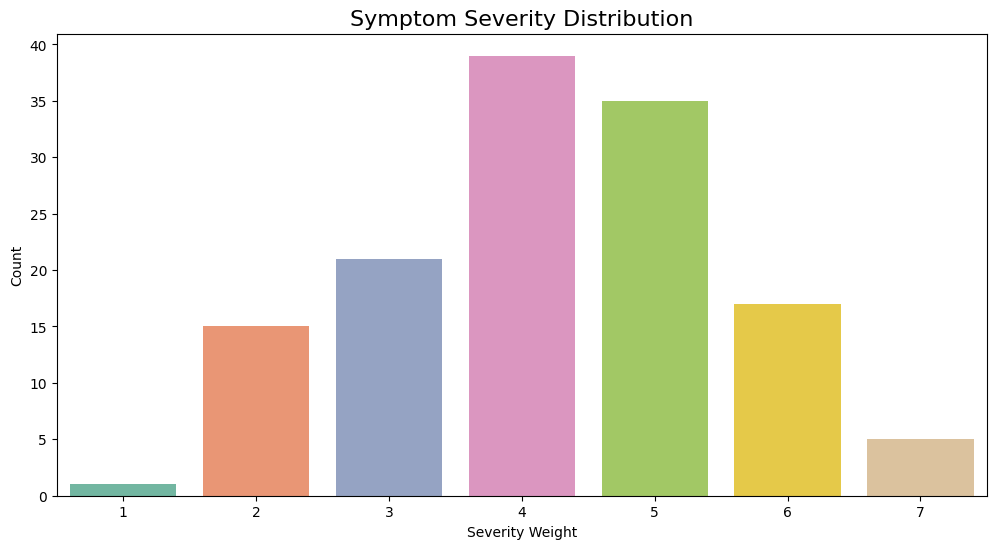

In [ ]:
# SYMPTOM SERVERITY DISTRIBUTION (BAR CHART):
import seaborn as sns, matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.countplot(data=symptom_severity, x="weight", palette="Set2")
plt.title("Symptom Severity Distribution", fontsize=16)
plt.xlabel("Severity Weight")
plt.ylabel("Count")
plt.show()


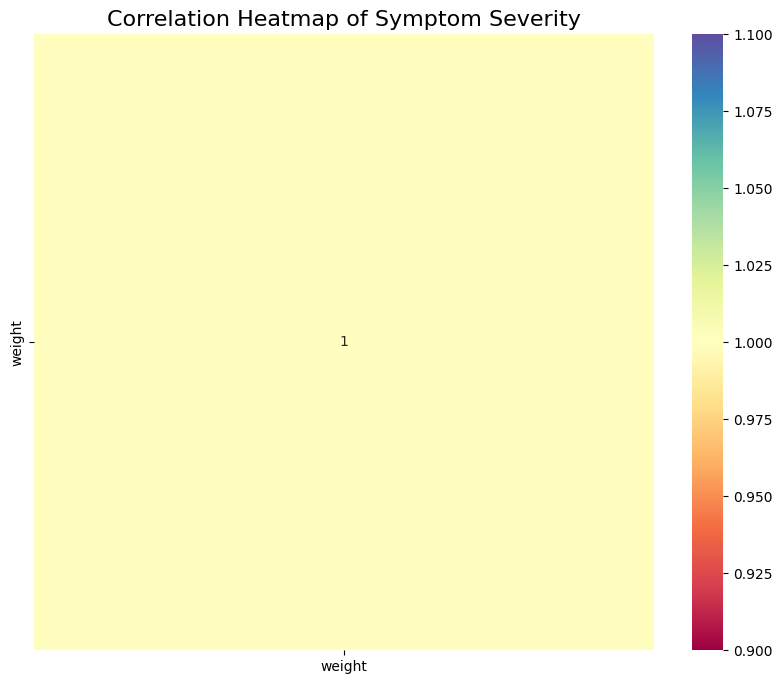

In [ ]:
# SYMPTOM SEVERITY (HEATMAP)
plt.figure(figsize=(10,8))
corr = symptom_severity[['weight']].corr()
sns.heatmap(corr, annot=True, cmap="Spectral", cbar=True)
plt.title("Correlation Heatmap of Symptom Severity", fontsize=16)
plt.show()


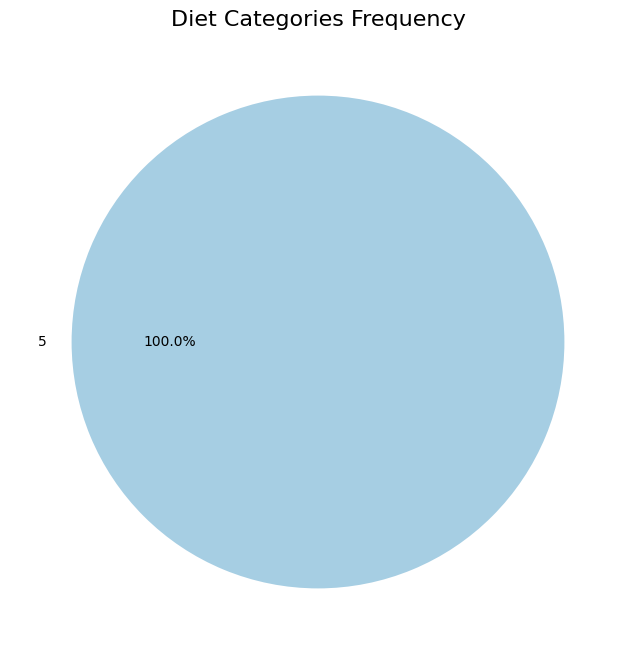

In [ ]:
# DIET CATEGORIES FREQUENCY (PIE CHART)
diet_counts = diets_df['Diet'].apply(lambda x: len(eval(x)) if isinstance(x,str) else 0)
plt.figure(figsize=(8,8))
plt.pie(diet_counts.value_counts(), labels=diet_counts.value_counts().index,
        autopct='%1.1f%%', colors=sns.color_palette("Paired"))
plt.title("Diet Categories Frequency", fontsize=16)
plt.show()


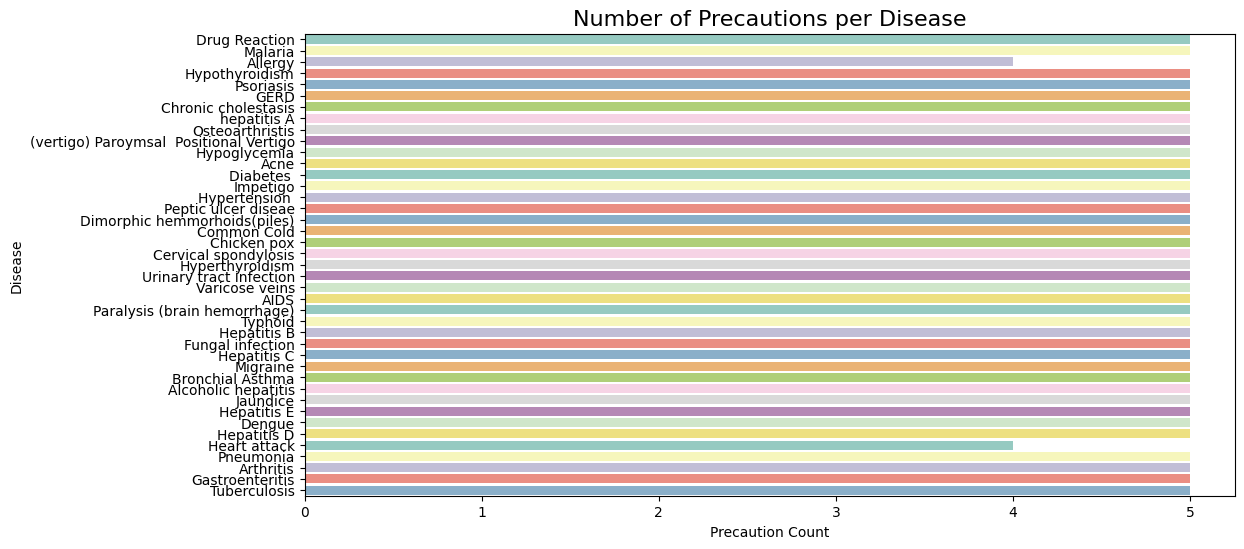

In [ ]:
# PRECAUTIONS PER DISEASE (HORIZONTAL BAR CHART)
prec_counts = precautions_df.drop(columns=['Disease']).count(axis=1)
plt.figure(figsize=(12,6))
sns.barplot(x=prec_counts, y=precautions_df['Disease'], palette="Set3")
plt.title("Number of Precautions per Disease", fontsize=16)
plt.xlabel("Precaution Count")
plt.ylabel("Disease")
plt.show()


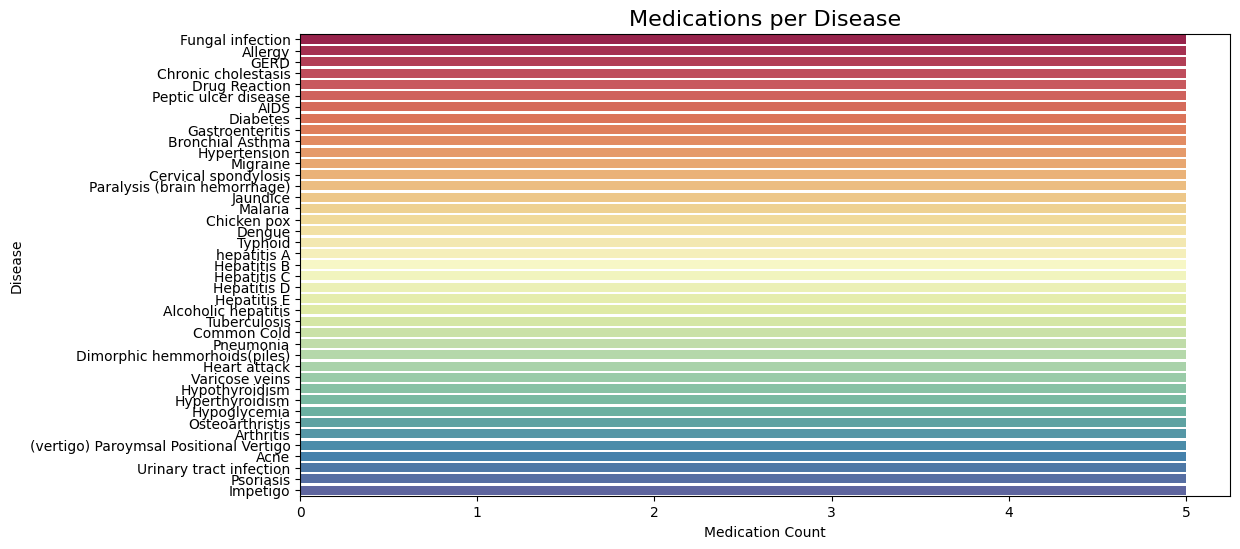

In [ ]:
# MEDICATIONS PER DISEASE (STACKED BAR CHART)
med_counts = medications_df['Medication'].apply(lambda x: len(eval(x)) if isinstance(x,str) else 0)
plt.figure(figsize=(12,6))
sns.barplot(x=med_counts, y=medications_df['Disease'], palette="Spectral")
plt.title("Medications per Disease", fontsize=16)
plt.xlabel("Medication Count")
plt.ylabel("Disease")
plt.show()


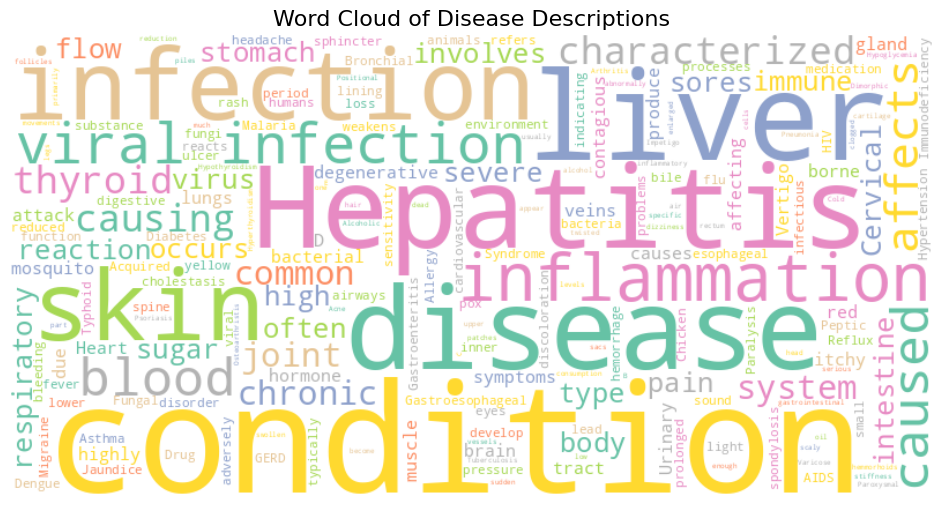

In [ ]:
# WORD CLOUD OF DISEASE DESCRIPTIONS
from wordcloud import WordCloud

text = " ".join(description_df['Description'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color="white",
                      colormap="Set2").generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Disease Descriptions", fontsize=16)
plt.show()


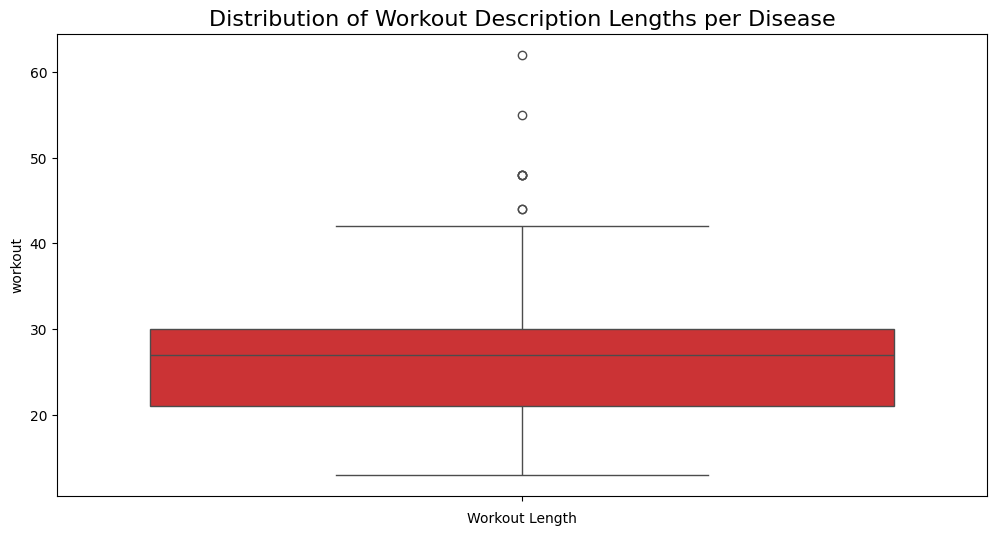

In [ ]:
# BOXPLOT OF WORKOUT LENGTHS PER DISEASE
workout_lengths = workout_df.groupby('disease')['workout'].apply(lambda x: x.str.len())
plt.figure(figsize=(12,6))
sns.boxplot(data=workout_lengths.explode(), palette="Set1")
plt.title("Distribution of Workout Description Lengths per Disease", fontsize=16)
plt.xlabel("Workout Length")
plt.show()


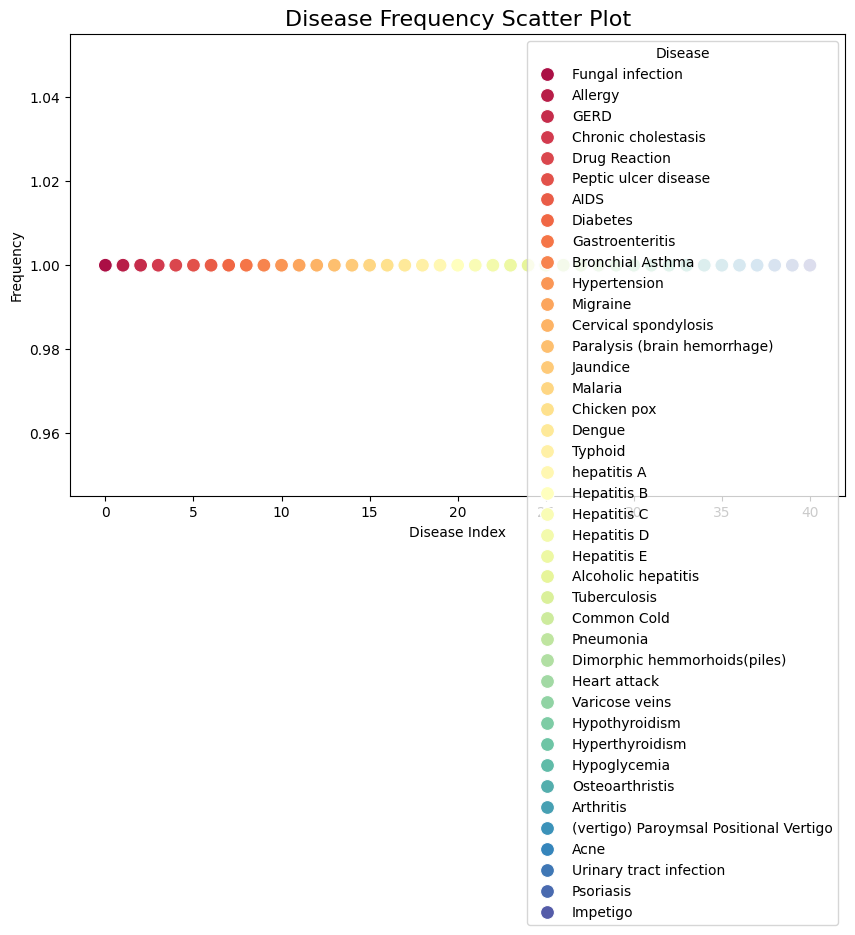

In [ ]:
# SCATTER PLOT : SYMPTOM SEVERITY VS DISEASE FREQUENCY
disease_counts = description_df['Disease'].value_counts()
plt.figure(figsize=(10,6))
sns.scatterplot(x=list(range(len(disease_counts))), y=disease_counts.values,
                hue=disease_counts.index, palette="Spectral", s=100)
plt.title("Disease Frequency Scatter Plot", fontsize=16)
plt.xlabel("Disease Index")
plt.ylabel("Frequency")
plt.show()


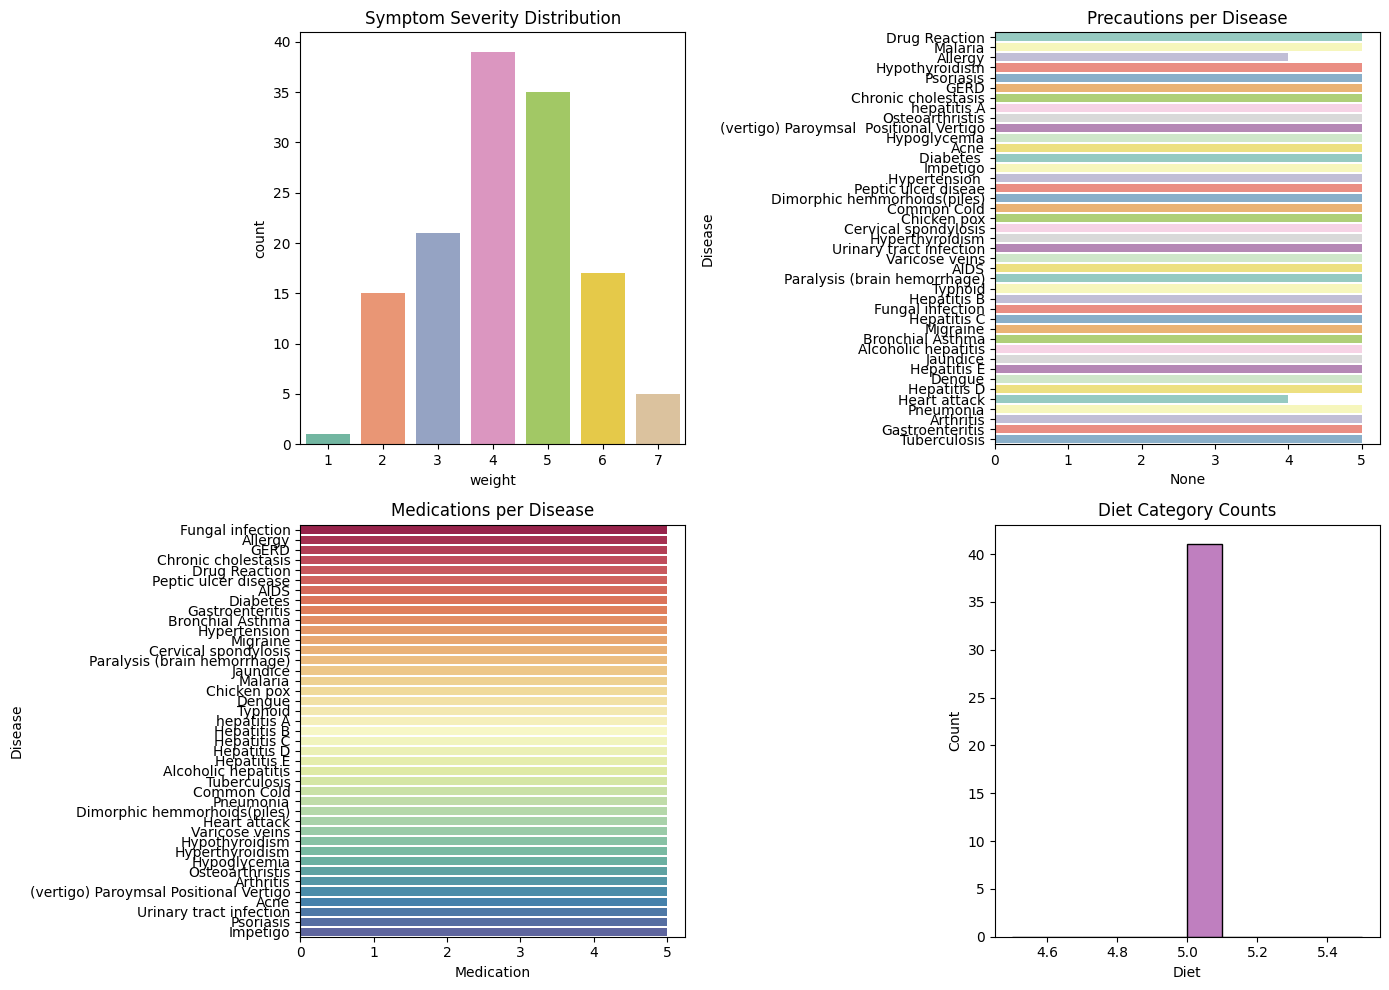

In [ ]:
# COMBINED DASHBOARD:
fig, axes = plt.subplots(2,2, figsize=(14,10))

sns.countplot(data=symptom_severity, x="weight", palette="Set2", ax=axes[0,0])
axes[0,0].set_title("Symptom Severity Distribution")

prec_counts = precautions_df.drop(columns=['Disease']).count(axis=1)
sns.barplot(x=prec_counts, y=precautions_df['Disease'], palette="Set3", ax=axes[0,1])
axes[0,1].set_title("Precautions per Disease")

med_counts = medications_df['Medication'].apply(lambda x: len(eval(x)) if isinstance(x,str) else 0)
sns.barplot(x=med_counts, y=medications_df['Disease'], palette="Spectral", ax=axes[1,0])
axes[1,0].set_title("Medications per Disease")

diet_counts = diets_df['Diet'].apply(lambda x: len(eval(x)) if isinstance(x,str) else 0)
sns.histplot(diet_counts, bins=10, kde=True, color="purple", ax=axes[1,1])
axes[1,1].set_title("Diet Category Counts")

plt.tight_layout()
plt.show()


In [ ]:
# INTERACTIVE DASHBOARD:
# Interactive Healthcare Dashboard with Plotly
import pandas as pd, numpy as np, re
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ---- Load datasets ----
symptom_severity = pd.read_csv('Symptom-severity.csv')
workout_df = pd.read_csv('workout_df.csv')
precautions_df = pd.read_csv('precautions_df.csv')
medications_df = pd.read_csv('medications.csv')
diets_df = pd.read_csv('diets.csv')
description_df = pd.read_csv('description.csv')

# ---- Prepare data summaries ----
# Symptom severity counts
severity_counts = symptom_severity['weight'].value_counts()

# Precaution counts per disease
prec_counts = precautions_df.drop(columns=['Disease']).count(axis=1)

# Medication counts per disease
med_counts = medications_df['Medication'].apply(lambda x: len(eval(x)) if isinstance(x,str) else 0)

# Diet counts per disease
diet_counts = diets_df['Diet'].apply(lambda x: len(eval(x)) if isinstance(x,str) else 0)

# Disease description word lengths
desc_lengths = description_df['Description'].apply(lambda x: len(str(x).split()))

# Workout description lengths
workout_lengths = workout_df['workout'].apply(lambda x: len(str(x)))

# ---- Build interactive dashboard ----
fig = make_subplots(
    rows=3, cols=3,
    subplot_titles=[
        "Symptom Severity Distribution",
        "Precautions per Disease",
        "Medications per Disease",
        "Diet Categories",
        "Description Lengths",
        "Workout Lengths",
        "Symptom Severity Histogram",
        "Disease Frequency",
        "Combined Overview"
    ],
    vertical_spacing=0.15, horizontal_spacing=0.1
)

# 1. Symptom severity bar
fig.add_trace(go.Bar(x=severity_counts.index, y=severity_counts.values,
                     marker=dict(color=severity_counts.values, colorscale='Viridis'),
                     name="Severity"), row=1, col=1)

# 2. Precautions bar
fig.add_trace(go.Bar(y=precautions_df['Disease'], x=prec_counts,
                     orientation='h', marker=dict(color=prec_counts, colorscale='Blues'),
                     name="Precautions"), row=1, col=2)

# 3. Medications bar
fig.add_trace(go.Bar(y=medications_df['Disease'], x=med_counts,
                     orientation='h', marker=dict(color=med_counts, colorscale='Reds'),
                     name="Medications"), row=1, col=3)

# 4. Diet histogram
fig.add_trace(go.Histogram(x=diet_counts, marker=dict(color='purple'),
                           name="Diet Counts"), row=2, col=1)

# 5. Description lengths
fig.add_trace(go.Box(y=desc_lengths, name="Description Lengths",
                     marker_color='orange'), row=2, col=2)

# 6. Workout lengths
fig.add_trace(go.Box(y=workout_lengths, name="Workout Lengths",
                     marker_color='green'), row=2, col=3)

# 7. Symptom severity histogram
fig.add_trace(go.Histogram(x=symptom_severity['weight'], marker=dict(color='teal'),
                           name="Severity Histogram"), row=3, col=1)

# 8. Disease frequency scatter
disease_counts = description_df['Disease'].value_counts()
fig.add_trace(go.Scatter(x=list(range(len(disease_counts))),
                         y=disease_counts.values,
                         mode='markers+text',
                         text=disease_counts.index,
                         textposition="top center",
                         marker=dict(size=12, color=disease_counts.values, colorscale='Spectral'),
                         name="Disease Frequency"), row=3, col=2)

# 9. Combined overview (stacked bar of meds + diets)
fig.add_trace(go.Bar(x=medications_df['Disease'], y=med_counts,
                     name="Medications", marker_color='crimson'),
              row=3, col=3)
fig.add_trace(go.Bar(x=diets_df['Disease'], y=diet_counts,
                     name="Diet", marker_color='royalblue'),
              row=3, col=3)

# ---- Layout ----
fig.update_layout(
    height=1200, width=1600,
    title_text="Interactive Healthcare Dataset Dashboard",
    showlegend=False
)

fig.show()


In [ ]:
# HEALTHCARE RECOMMENDATION SYSTEM:
# Input: disease name or free-text symptoms
# Output: Table with all aspects (Predicted Disease, Symptoms, Description, Precautions, Medications, Diet, Workouts)

import pandas as pd, numpy as np, re
from fuzzywuzzy import process
from tabulate import tabulate

# Load datasets
symptom_severity = pd.read_csv('Symptom-severity.csv')
workout_df       = pd.read_csv('workout_df.csv')
precautions_df   = pd.read_csv('precautions_df.csv')
medications_df   = pd.read_csv('medications.csv')
diets_df         = pd.read_csv('diets.csv')
description_df   = pd.read_csv('description.csv')

# Helpers
def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

def safe_eval_list(s):
    s = str(s)
    try:
        val = eval(s, {"__builtins__": None}, {})
        return list(val) if isinstance(val, (list, tuple)) else [str(s)]
    except Exception:
        return [x.strip() for x in s.split(',') if x.strip()]

# Build symptom dictionary
symptom_severity['Symptom_norm'] = symptom_severity['Symptom'].apply(normalize_text)
SYMPTOM_LIST = symptom_severity['Symptom_norm'].tolist()

def match_symptom(token, choices=SYMPTOM_LIST, threshold=80):
    token = normalize_text(token)
    if not choices: return None
    best = process.extractOne(token, choices)
    if not best: return None
    name, score = best
    return name if score >= threshold else None

# Accessors
def get_description(disease):
    d = normalize_text(disease)
    row = description_df[description_df['Disease'].apply(normalize_text)==d]
    return '' if row.empty else row['Description'].values[0]

def get_precautions(disease):
    d = normalize_text(disease)
    row = precautions_df[precautions_df['Disease'].apply(normalize_text)==d]
    if row.empty: return []
    r = row.iloc[0]
    return [x for x in [r.get('Precaution_1'), r.get('Precaution_2'),
                        r.get('Precaution_3'), r.get('Precaution_4')]
            if pd.notna(x) and str(x).strip()]

def get_medications(disease):
    d = normalize_text(disease)
    row = medications_df[medications_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Medication'].values[0])

def get_diet(disease):
    d = normalize_text(disease)
    row = diets_df[diets_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Diet'].values[0])

def get_workouts(disease, k=10):
    d = normalize_text(disease)
    rows = workout_df[workout_df['disease'].apply(normalize_text)==d]['workout'].tolist()
    return rows[:k]

# Main function
def healthcare_recommendation(input_text):
    d_norm = normalize_text(input_text)
    disease_row = description_df[description_df['Disease'].apply(normalize_text)==d_norm]

    if not disease_row.empty:
        disease_pred = disease_row['Disease'].values[0]
        matched_symptoms = []
    else:
        syms = [normalize_text(s) for s in re.split(r'[;,]', input_text) if s.strip()]
        matched = [match_symptom(s) for s in syms if match_symptom(s)]
        matched_symptoms = matched
        # fallback naive scoring
        all_diseases = list(description_df['Disease'].apply(normalize_text))
        scores = {d: sum(1 for s in matched if s in d) for d in all_diseases}
        disease_pred = max(scores, key=scores.get) if scores else "unknown"

    bundle = {
        "Input": input_text,
        "Predicted Disease": disease_pred,
        "Matched Symptoms": ", ".join(matched_symptoms) if matched_symptoms else "-",
        "Description": get_description(disease_pred),
        "Precautions": ", ".join(get_precautions(disease_pred)) if get_precautions(disease_pred) else "-",
        "Medications": ", ".join(get_medications(disease_pred)) if get_medications(disease_pred) else "-",
        "Diet": ", ".join(get_diet(disease_pred)) if get_diet(disease_pred) else "-",
        "Workouts": ", ".join(get_workouts(disease_pred)) if get_workouts(disease_pred) else "-"
    }
    return bundle

#  Demo: Multiple Inputs
demo_inputs = [
    "aids",
    "high fever, cough, patches in throat",
    "chest pain, dizziness",
    "itching, skin rash, nodal skin eruptions"
]

rows = []
for inp in demo_inputs:
    result = healthcare_recommendation(inp)
    rows.append(result)

df_final = pd.DataFrame(rows)

# Final Table Output
print("\nHealthcare Recommendation Table")
print(tabulate(df_final, headers="keys", tablefmt="grid", showindex=False))



Healthcare Recommendation Table
+------------------------------------------+---------------------+------------------------------------------+------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Input                                    | Predicted Disease   | Matched Symptoms                         | Description                                                              

In [ ]:
# Disease Recommendation Printer
# Usage:
#   show_recommendations("aids")
#   show_recommendations("diabetes")
# Prints a labeled block with: Description, Precautions, Medications, Diet, Workouts

import pandas as pd, re

#  Load datasets (ensure these CSVs exist in your runtime)
symptom_severity = pd.read_csv('Symptom-severity.csv')     # not directly used, but can be referenced
workout_df       = pd.read_csv('workout_df.csv')           # columns: disease, workout
precautions_df   = pd.read_csv('precautions_df.csv')       # columns: Disease, Precaution_1..4
medications_df   = pd.read_csv('medications.csv')          # columns: Disease, Medication (list or comma string)
diets_df         = pd.read_csv('diets.csv')                # columns: Disease, Diet (list or comma string)
description_df   = pd.read_csv('description.csv')          # columns: Disease, Description

def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

def safe_to_list(v):
    # Convert list-like strings into Python lists; else split by comma
    if isinstance(v, list): return v
    s = str(v)
    try:
        val = eval(s, {"__builtins__": None}, {})
        if isinstance(val, (list, tuple)): return list(val)
    except Exception:
        pass
    return [x.strip() for x in s.split(',') if x and x.strip()]

def get_description(disease):
    d = normalize_text(disease)
    row = description_df[description_df['Disease'].apply(normalize_text) == d]
    return '' if row.empty else str(row['Description'].values[0])

def get_precautions(disease):
    d = normalize_text(disease)
    row = precautions_df[precautions_df['Disease'].apply(normalize_text) == d]
    if row.empty: return []
    r = row.iloc[0]
    precs = [r.get('Precaution_1'), r.get('Precaution_2'), r.get('Precaution_3'), r.get('Precaution_4')]
    return [p for p in precs if pd.notna(p) and str(p).strip()]

def get_medications(disease):
    d = normalize_text(disease)
    row = medications_df[medications_df['Disease'].apply(normalize_text) == d]
    return [] if row.empty else safe_to_list(row['Medication'].values[0])

def get_diet(disease):
    d = normalize_text(disease)
    row = diets_df[diets_df['Disease'].apply(normalize_text) == d]
    return [] if row.empty else safe_to_list(row['Diet'].values[0])

def get_workouts(disease, k=10):
    d = normalize_text(disease)
    items = workout_df[workout_df['disease'].apply(normalize_text) == d]['workout'].tolist()
    return items[:k]

def show_recommendations(disease_name: str):
    d_clean = normalize_text(disease_name)
    # Validate disease exists in any dataset
    exists = any([
        not description_df[description_df['Disease'].apply(normalize_text)==d_clean].empty,
        not precautions_df[precautions_df['Disease'].apply(normalize_text)==d_clean].empty,
        not medications_df[medications_df['Disease'].apply(normalize_text)==d_clean].empty,
        not diets_df[diets_df['Disease'].apply(normalize_text)==d_clean].empty,
        not workout_df[workout_df['disease'].apply(normalize_text)==d_clean].empty,
    ])
    if not exists:
        print(f"No matching disease found for: {disease_name}")
        return

    desc = get_description(d_clean)
    precs = get_precautions(d_clean)
    meds  = get_medications(d_clean)
    diet  = get_diet(d_clean)
    wkts  = get_workouts(d_clean)

    # Pretty, labeled block output
    print("\n==================================================")
    print(f"Disease: {disease_name}")
    print("--------------------------------------------------")
    print("Description:")
    print(f"  - {desc if desc else 'No description available'}")
    print("--------------------------------------------------")
    print("Precautions:")
    if precs:
        for i, p in enumerate(precs, 1):
            print(f"  {i}. {p}")
    else:
        print("  - No precautions listed")
    print("--------------------------------------------------")
    print("Medications:")
    if meds:
        for i, m in enumerate(meds, 1):
            print(f"  {i}. {m}")
    else:
        print("  - No medications listed")
    print("--------------------------------------------------")
    print("Diet plan:")
    if diet:
        for i, d in enumerate(diet, 1):
            print(f"  {i}. {d}")
    else:
        print("  - No diet items listed")
    print("--------------------------------------------------")
    print("Workouts / Lifestyle tips:")
    if wkts:
        for i, w in enumerate(wkts, 1):
            print(f"  {i}. {w}")
    else:
        print("  - No workouts listed")
    print("==================================================\n")

#  Example usage
# Try any disease present in your datasets:
show_recommendations("aids")
# show_recommendations("fungal infection")
# show_recommendations("diabetes")
# show_recommendations("hypertension")



Disease: aids
--------------------------------------------------
Description:
  - AIDS (Acquired Immunodeficiency Syndrome) is a disease caused by HIV that weakens the immune system.
--------------------------------------------------
Precautions:
  1. avoid open cuts
  2. wear ppe if possible
  3. consult doctor
  4. follow up
--------------------------------------------------
Medications:
  1. Antiretroviral drugs
  2. Protease inhibitors
  3. Integrase inhibitors
  4. Entry inhibitors
  5. Fusion inhibitors
--------------------------------------------------
Diet plan:
  1. Balanced Diet
  2. Protein-rich foods
  3. Fruits and vegetables
  4. Whole grains
  5. Healthy fats
--------------------------------------------------
Workouts / Lifestyle tips:
  1. Follow a balanced and nutritious diet
  2. Include lean proteins
  3. Consume nutrient-rich foods
  4. Stay hydrated
  5. Include healthy fats
  6. Avoid raw or undercooked foods
  7. Limit sugary foods and beverages
  8. Consume imm

In [ ]:
# Healthcare Recommendation System (Interactive Input)
# After running this cell, it will ask: "Enter the disease:"
# You type e.g. diabetes, aids, hypertension, etc.
# It will then print all details: description, precautions, medications, diet, workouts.

import pandas as pd, re

#  Load datasets
symptom_severity = pd.read_csv('Symptom-severity.csv')
workout_df       = pd.read_csv('workout_df.csv')
precautions_df   = pd.read_csv('precautions_df.csv')
medications_df   = pd.read_csv('medications.csv')
diets_df         = pd.read_csv('diets.csv')
description_df   = pd.read_csv('description.csv')

#  Helpers
def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

def safe_eval_list(s):
    s = str(s)
    try:
        val = eval(s, {"__builtins__": None}, {})
        if isinstance(val, (list, tuple)): return list(val)
    except Exception:
        pass
    return [x.strip() for x in s.split(',') if x.strip()]

def get_description(disease):
    d = normalize_text(disease)
    row = description_df[description_df['Disease'].apply(normalize_text)==d]
    return '' if row.empty else str(row['Description'].values[0])

def get_precautions(disease):
    d = normalize_text(disease)
    row = precautions_df[precautions_df['Disease'].apply(normalize_text)==d]
    if row.empty: return []
    r = row.iloc[0]
    precs = [r.get('Precaution_1'), r.get('Precaution_2'),
             r.get('Precaution_3'), r.get('Precaution_4')]
    return [p for p in precs if pd.notna(p) and str(p).strip()]

def get_medications(disease):
    d = normalize_text(disease)
    row = medications_df[medications_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Medication'].values[0])

def get_diet(disease):
    d = normalize_text(disease)
    row = diets_df[diets_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Diet'].values[0])

def get_workouts(disease, k=10):
    d = normalize_text(disease)
    items = workout_df[workout_df['disease'].apply(normalize_text)==d]['workout'].tolist()
    return items[:k]

def show_recommendations(disease_name: str):
    d_clean = normalize_text(disease_name)
    desc = get_description(d_clean)
    precs = get_precautions(d_clean)
    meds  = get_medications(d_clean)
    diet  = get_diet(d_clean)
    wkts  = get_workouts(d_clean)

    print("\n==================================================")
    print(f"Disease: {disease_name}")
    print("--------------------------------------------------")
    print("Description:")
    print(f"  - {desc if desc else 'No description available'}")
    print("--------------------------------------------------")
    print("Precautions:")
    if precs:
        for i, p in enumerate(precs, 1):
            print(f"  {i}. {p}")
    else:
        print("  - No precautions listed")
    print("--------------------------------------------------")
    print("Medications:")
    if meds:
        for i, m in enumerate(meds, 1):
            print(f"  {i}. {m}")
    else:
        print("  - No medications listed")
    print("--------------------------------------------------")
    print("Diet plan:")
    if diet:
        for i, d in enumerate(diet, 1):
            print(f"  {i}. {d}")
    else:
        print("  - No diet items listed")
    print("--------------------------------------------------")
    print("Workouts / Lifestyle tips:")
    if wkts:
        for i, w in enumerate(wkts, 1):
            print(f"  {i}. {w}")
    else:
        print("  - No workouts listed")
    print("==================================================\n")

#  Interactive run
user_input = input("Enter the disease: ")
show_recommendations(user_input)


Enter the disease: diabetes

Disease: diabetes
--------------------------------------------------
Description:
  - Diabetes is a chronic condition that affects how the body processes blood sugar.
--------------------------------------------------
Precautions:
  1. have balanced diet
  2. exercise
  3. consult doctor
  4. follow up
--------------------------------------------------
Medications:
  1. Insulin
  2. Metformin
  3. Sulfonylureas
  4. DPP-4 inhibitors
  5. GLP-1 receptor agonists
--------------------------------------------------
Diet plan:
  1. Low-Glycemic Diet
  2. Fiber-rich foods
  3. Lean proteins
  4. Healthy fats
  5. Low-fat dairy
--------------------------------------------------
Workouts / Lifestyle tips:
  1. Monitor carbohydrate intake
  2. Eat balanced meals
  3. Include lean proteins
  4. Consume high-fiber foods
  5. Stay hydrated
  6. Limit sugary foods and beverages
  7. Include healthy fats
  8. Monitor blood sugar levels
  9. Consult a registered dietitian

In [ ]:
# Healthcare Recommendation System (Interactive + Fuzzy Matching)
# After running this cell, it will ask: "Enter the disease:"
# You type e.g. diabetes, aids, hypertensn (misspelled), etc.
# It will guess the closest disease and print all details.

import pandas as pd, re
from fuzzywuzzy import process

# Load datasets
symptom_severity = pd.read_csv('Symptom-severity.csv')
workout_df       = pd.read_csv('workout_df.csv')
precautions_df   = pd.read_csv('precautions_df.csv')
medications_df   = pd.read_csv('medications.csv')
diets_df         = pd.read_csv('diets.csv')
description_df   = pd.read_csv('description.csv')

# Helpers
def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

def safe_eval_list(s):
    s = str(s)
    try:
        val = eval(s, {"__builtins__": None}, {})
        if isinstance(val, (list, tuple)): return list(val)
    except Exception:
        pass
    return [x.strip() for x in s.split(',') if x.strip()]

def get_description(disease):
    d = normalize_text(disease)
    row = description_df[description_df['Disease'].apply(normalize_text)==d]
    return '' if row.empty else str(row['Description'].values[0])

def get_precautions(disease):
    d = normalize_text(disease)
    row = precautions_df[precautions_df['Disease'].apply(normalize_text)==d]
    if row.empty: return []
    r = row.iloc[0]
    precs = [r.get('Precaution_1'), r.get('Precaution_2'),
             r.get('Precaution_3'), r.get('Precaution_4')]
    return [p for p in precs if pd.notna(p) and str(p).strip()]

def get_medications(disease):
    d = normalize_text(disease)
    row = medications_df[medications_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Medication'].values[0])

def get_diet(disease):
    d = normalize_text(disease)
    row = diets_df[diets_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Diet'].values[0])

def get_workouts(disease, k=10):
    d = normalize_text(disease)
    items = workout_df[workout_df['disease'].apply(normalize_text)==d]['workout'].tolist()
    return items[:k]

def show_recommendations(user_input: str):
    # Fuzzy match against all known diseases
    all_diseases = description_df['Disease'].dropna().tolist()
    best_match, score = process.extractOne(user_input, all_diseases)
    disease_name = best_match if score >= 60 else user_input  # threshold

    desc = get_description(disease_name)
    precs = get_precautions(disease_name)
    meds  = get_medications(disease_name)
    diet  = get_diet(disease_name)
    wkts  = get_workouts(disease_name)

    print("\n==================================================")
    print(f"Input given: {user_input}")
    print(f"Matched disease: {disease_name} (confidence {score}%)")
    print("--------------------------------------------------")
    print("Description:")
    print(f"  - {desc if desc else 'No description available'}")
    print("--------------------------------------------------")
    print("Precautions:")
    if precs:
        for i, p in enumerate(precs, 1):
            print(f"  {i}. {p}")
    else:
        print("  - No precautions listed")
    print("--------------------------------------------------")
    print("Medications:")
    if meds:
        for i, m in enumerate(meds, 1):
            print(f"  {i}. {m}")
    else:
        print("  - No medications listed")
    print("--------------------------------------------------")
    print("Diet plan:")
    if diet:
        for i, d in enumerate(diet, 1):
            print(f"  {i}. {d}")
    else:
        print("  - No diet items listed")
    print("--------------------------------------------------")
    print("Workouts / Lifestyle tips:")
    if wkts:
        for i, w in enumerate(wkts, 1):
            print(f"  {i}. {w}")
    else:
        print("  - No workouts listed")
    print("==================================================\n")

# Interactive run
user_input = input("Enter the disease: ")
show_recommendations(user_input)


Enter the disease: diabetics

Input given: diabetics
Matched disease: Diabetes (confidence 82%)
--------------------------------------------------
Description:
  - Diabetes is a chronic condition that affects how the body processes blood sugar.
--------------------------------------------------
Precautions:
  1. have balanced diet
  2. exercise
  3. consult doctor
  4. follow up
--------------------------------------------------
Medications:
  1. Insulin
  2. Metformin
  3. Sulfonylureas
  4. DPP-4 inhibitors
  5. GLP-1 receptor agonists
--------------------------------------------------
Diet plan:
  1. Low-Glycemic Diet
  2. Fiber-rich foods
  3. Lean proteins
  4. Healthy fats
  5. Low-fat dairy
--------------------------------------------------
Workouts / Lifestyle tips:
  1. Monitor carbohydrate intake
  2. Eat balanced meals
  3. Include lean proteins
  4. Consume high-fiber foods
  5. Stay hydrated
  6. Limit sugary foods and beverages
  7. Include healthy fats
  8. Monitor blood

In [ ]:
# Healthcare Recommendation System (Disease or Symptom Input)
# After running this cell, it will ask: "Enter disease or symptoms:"
# You can type either a disease name (e.g., diabetes) or symptoms (e.g., high fever, cough).
# It will predict the disease if symptoms are given, then print all details.

import pandas as pd, re
from fuzzywuzzy import process

# Load datasets
symptom_severity = pd.read_csv('Symptom-severity.csv')
workout_df       = pd.read_csv('workout_df.csv')
precautions_df   = pd.read_csv('precautions_df.csv')
medications_df   = pd.read_csv('medications.csv')
diets_df         = pd.read_csv('diets.csv')
description_df   = pd.read_csv('description.csv')

# Helpers
def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

def safe_eval_list(s):
    s = str(s)
    try:
        val = eval(s, {"__builtins__": None}, {})
        if isinstance(val, (list, tuple)): return list(val)
    except Exception:
        pass
    return [x.strip() for x in s.split(',') if x.strip()]

# Build symptom dictionary
symptom_severity['Symptom_norm'] = symptom_severity['Symptom'].apply(normalize_text)
SYMPTOM_LIST = symptom_severity['Symptom_norm'].tolist()

def match_symptom(token, choices=SYMPTOM_LIST, threshold=80):
    token = normalize_text(token)
    if not choices: return None
    best = process.extractOne(token, choices)
    if not best: return None
    name, score = best
    return name if score >= threshold else None

# Accessors
def get_description(disease):
    d = normalize_text(disease)
    row = description_df[description_df['Disease'].apply(normalize_text)==d]
    return '' if row.empty else str(row['Description'].values[0])

def get_precautions(disease):
    d = normalize_text(disease)
    row = precautions_df[precautions_df['Disease'].apply(normalize_text)==d]
    if row.empty: return []
    r = row.iloc[0]
    precs = [r.get('Precaution_1'), r.get('Precaution_2'),
             r.get('Precaution_3'), r.get('Precaution_4')]
    return [p for p in precs if pd.notna(p) and str(p).strip()]

def get_medications(disease):
    d = normalize_text(disease)
    row = medications_df[medications_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Medication'].values[0])

def get_diet(disease):
    d = normalize_text(disease)
    row = diets_df[diets_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Diet'].values[0])

def get_workouts(disease, k=10):
    d = normalize_text(disease)
    items = workout_df[workout_df['disease'].apply(normalize_text)==d]['workout'].tolist()
    return items[:k]

# Main Recommendation Function
def healthcare_recommendation(user_input: str):
    d_norm = normalize_text(user_input)

    # Try direct disease match
    disease_row = description_df[description_df['Disease'].apply(normalize_text)==d_norm]
    if not disease_row.empty:
        disease_pred = disease_row['Disease'].values[0]
    else:
        # Treat input as symptoms
        syms = [normalize_text(s) for s in re.split(r'[;,]', user_input) if s.strip()]
        matched = [match_symptom(s) for s in syms if match_symptom(s)]
        # Fallback: fuzzy match against disease names
        all_diseases = description_df['Disease'].dropna().tolist()
        best_match, score = process.extractOne(user_input, all_diseases)
        disease_pred = best_match if score >= 60 else "unknown"

    # Build bundle
    bundle = {
        "Input": user_input,
        "Predicted Disease": disease_pred,
        "Description": get_description(disease_pred),
        "Precautions": get_precautions(disease_pred),
        "Medications": get_medications(disease_pred),
        "Diet": get_diet(disease_pred),
        "Workouts": get_workouts(disease_pred)
    }
    return bundle

def show_recommendations(user_input: str):
    result = healthcare_recommendation(user_input)
    print("\n==================================================")
    print(f"Input given: {result['Input']}")
    print(f"Predicted Disease: {result['Predicted Disease']}")
    print("--------------------------------------------------")
    print("Description:")
    print(f"  - {result['Description'] if result['Description'] else 'No description available'}")
    print("--------------------------------------------------")
    print("Precautions:")
    if result['Precautions']:
        for i, p in enumerate(result['Precautions'], 1):
            print(f"  {i}. {p}")
    else:
        print("  - No precautions listed")
    print("--------------------------------------------------")
    print("Medications:")
    if result['Medications']:
        for i, m in enumerate(result['Medications'], 1):
            print(f"  {i}. {m}")
    else:
        print("  - No medications listed")
    print("--------------------------------------------------")
    print("Diet plan:")
    if result['Diet']:
        for i, d in enumerate(result['Diet'], 1):
            print(f"  {i}. {d}")
    else:
        print("  - No diet items listed")
    print("--------------------------------------------------")
    print("Workouts / Lifestyle tips:")
    if result['Workouts']:
        for i, w in enumerate(result['Workouts'], 1):
            print(f"  {i}. {w}")
    else:
        print("  - No workouts listed")
    print("==================================================\n")

# Interactive run
user_input = input("Enter disease name or symptoms: ")
show_recommendations(user_input)


Enter disease name or symptoms: hypertension and sugar

Input given: hypertension and sugar
Predicted Disease: Hypertension
--------------------------------------------------
Description:
  - Hypertension, or high blood pressure, is a common cardiovascular condition.
--------------------------------------------------
Precautions:
  1. meditation
  2. salt baths
  3. reduce stress
  4. get proper sleep
--------------------------------------------------
Medications:
  1. Antihypertensive medications
  2. Diuretics
  3. Beta-blockers
  4. ACE inhibitors
  5. Calcium channel blockers
--------------------------------------------------
Diet plan:
  1. DASH Diet
  2. Low-sodium foods
  3. Fruits and vegetables
  4. Whole grains
  5. Lean proteins
--------------------------------------------------
Workouts / Lifestyle tips:
  1. Follow the DASH diet (Dietary Approaches to Stop Hypertension)
  2. Limit sodium intake
  3. Include potassium-rich foods
  4. Stay hydrated
  5. Consume calcium-rich 

In [ ]:
# Healthcare Recommendation System (Disease or Symptom Input)
# After running this cell, it will ask: "Enter disease or symptoms:"
# You can type either a disease name (e.g., diabetes) or symptoms (e.g., high fever, cough).
# It will predict the disease if symptoms are given, then print all details.

import pandas as pd, re
from fuzzywuzzy import process

# Load datasets
symptom_severity = pd.read_csv('Symptom-severity.csv')
workout_df       = pd.read_csv('workout_df.csv')
precautions_df   = pd.read_csv('precautions_df.csv')
medications_df   = pd.read_csv('medications.csv')
diets_df         = pd.read_csv('diets.csv')
description_df   = pd.read_csv('description.csv')

# Helpers
def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

def safe_eval_list(s):
    s = str(s)
    try:
        val = eval(s, {"__builtins__": None}, {})
        if isinstance(val, (list, tuple)): return list(val)
    except Exception:
        pass
    return [x.strip() for x in s.split(',') if x.strip()]

# Build symptom dictionary
symptom_severity['Symptom_norm'] = symptom_severity['Symptom'].apply(normalize_text)
SYMPTOM_LIST = symptom_severity['Symptom_norm'].tolist()

def match_symptom(token, choices=SYMPTOM_LIST, threshold=80):
    token = normalize_text(token)
    if not choices: return None
    best = process.extractOne(token, choices)
    if not best: return None
    name, score = best
    return name if score >= threshold else None

# Accessors
def get_description(disease):
    d = normalize_text(disease)
    row = description_df[description_df['Disease'].apply(normalize_text)==d]
    return '' if row.empty else str(row['Description'].values[0])

def get_precautions(disease):
    d = normalize_text(disease)
    row = precautions_df[precautions_df['Disease'].apply(normalize_text)==d]
    if row.empty: return []
    r = row.iloc[0]
    precs = [r.get('Precaution_1'), r.get('Precaution_2'),
             r.get('Precaution_3'), r.get('Precaution_4')]
    return [p for p in precs if pd.notna(p) and str(p).strip()]

def get_medications(disease):
    d = normalize_text(disease)
    row = medications_df[medications_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Medication'].values[0])

def get_diet(disease):
    d = normalize_text(disease)
    row = diets_df[diets_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Diet'].values[0])

def get_workouts(disease, k=10):
    d = normalize_text(disease)
    items = workout_df[workout_df['disease'].apply(normalize_text)==d]['workout'].tolist()
    return items[:k]

# Main Recommendation Function
def healthcare_recommendation(user_input: str):
    d_norm = normalize_text(user_input)

    # Try direct disease match
    disease_row = description_df[description_df['Disease'].apply(normalize_text)==d_norm]
    if not disease_row.empty:
        disease_pred = disease_row['Disease'].values[0]
    else:
        # Treat input as symptoms
        syms = [normalize_text(s) for s in re.split(r'[;,]', user_input) if s.strip()]
        matched = [match_symptom(s) for s in syms if match_symptom(s)]
        # Fallback: fuzzy match against disease names
        all_diseases = description_df['Disease'].dropna().tolist()
        best_match, score = process.extractOne(user_input, all_diseases)
        disease_pred = best_match if score >= 60 else "unknown"

    # Build bundle
    bundle = {
        "Input": user_input,
        "Predicted Disease": disease_pred,
        "Description": get_description(disease_pred),
        "Precautions": get_precautions(disease_pred),
        "Medications": get_medications(disease_pred),
        "Diet": get_diet(disease_pred),
        "Workouts": get_workouts(disease_pred)
    }
    return bundle

def show_recommendations(user_input: str):
    result = healthcare_recommendation(user_input)
    print("\n==================================================")
    print(f"Input given: {result['Input']}")
    print(f"Predicted Disease: {result['Predicted Disease']}")
    print("--------------------------------------------------")
    print("Description:")
    print(f"  - {result['Description'] if result['Description'] else 'No description available'}")
    print("--------------------------------------------------")
    print("Precautions:")
    if result['Precautions']:
        for i, p in enumerate(result['Precautions'], 1):
            print(f"  {i}. {p}")
    else:
        print("  - No precautions listed")
    print("--------------------------------------------------")
    print("Medications:")
    if result['Medications']:
        for i, m in enumerate(result['Medications'], 1):
            print(f"  {i}. {m}")
    else:
        print("  - No medications listed")
    print("--------------------------------------------------")
    print("Diet plan:")
    if result['Diet']:
        for i, d in enumerate(result['Diet'], 1):
            print(f"  {i}. {d}")
    else:
        print("  - No diet items listed")
    print("--------------------------------------------------")
    print("Workouts / Lifestyle tips:")
    if result['Workouts']:
        for i, w in enumerate(result['Workouts'], 1):
            print(f"  {i}. {w}")
    else:
        print("  - No workouts listed")
    print("==================================================\n")

# Interactive run
user_input = input("Enter disease name or symptoms: ")
show_recommendations(user_input)


Enter disease name or symptoms: vomiting

Input given: vomiting
Predicted Disease: unknown
--------------------------------------------------
Description:
  - No description available
--------------------------------------------------
Precautions:
  - No precautions listed
--------------------------------------------------
Medications:
  - No medications listed
--------------------------------------------------
Diet plan:
  - No diet items listed
--------------------------------------------------
Workouts / Lifestyle tips:
  - No workouts listed



In [ ]:
# Healthcare Recommendation System (Disease or Symptom Input with Fallback Guess)
# After running this cell, it will ask: "Enter disease name or symptoms:"
# You can type either a disease name (e.g., diabetes) or symptoms (e.g., vomiting, high fever, cough).
# It will guess the closest disease if exact match is not found, then print all details.

import pandas as pd, re
from fuzzywuzzy import process

# Load datasets
symptom_severity = pd.read_csv('Symptom-severity.csv')
workout_df       = pd.read_csv('workout_df.csv')
precautions_df   = pd.read_csv('precautions_df.csv')
medications_df   = pd.read_csv('medications.csv')
diets_df         = pd.read_csv('diets.csv')
description_df   = pd.read_csv('description.csv')

# Helpers
def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

def safe_eval_list(s):
    s = str(s)
    try:
        val = eval(s, {"__builtins__": None}, {})
        if isinstance(val, (list, tuple)): return list(val)
    except Exception:
        pass
    return [x.strip() for x in s.split(',') if x.strip()]

# Build symptom dictionary
symptom_severity['Symptom_norm'] = symptom_severity['Symptom'].apply(normalize_text)
SYMPTOM_LIST = symptom_severity['Symptom_norm'].tolist()

def match_symptom(token, choices=SYMPTOM_LIST, threshold=70):
    token = normalize_text(token)
    if not choices: return None
    best = process.extractOne(token, choices)
    if not best: return None
    name, score = best
    return name if score >= threshold else None

# Accessors
def get_description(disease):
    d = normalize_text(disease)
    row = description_df[description_df['Disease'].apply(normalize_text)==d]
    return '' if row.empty else str(row['Description'].values[0])

def get_precautions(disease):
    d = normalize_text(disease)
    row = precautions_df[precautions_df['Disease'].apply(normalize_text)==d]
    if row.empty: return []
    r = row.iloc[0]
    precs = [r.get('Precaution_1'), r.get('Precaution_2'),
             r.get('Precaution_3'), r.get('Precaution_4')]
    return [p for p in precs if pd.notna(p) and str(p).strip()]

def get_medications(disease):
    d = normalize_text(disease)
    row = medications_df[medications_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Medication'].values[0])

def get_diet(disease):
    d = normalize_text(disease)
    row = diets_df[diets_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Diet'].values[0])

def get_workouts(disease, k=10):
    d = normalize_text(disease)
    items = workout_df[workout_df['disease'].apply(normalize_text)==d]['workout'].tolist()
    return items[:k]

# Main Recommendation Function
def healthcare_recommendation(user_input: str):
    d_norm = normalize_text(user_input)

    # Try direct disease match
    disease_row = description_df[description_df['Disease'].apply(normalize_text)==d_norm]
    if not disease_row.empty:
        disease_pred = disease_row['Disease'].values[0]
    else:
        # Treat input as symptoms
        syms = [normalize_text(s) for s in re.split(r'[;, ]', user_input) if s.strip()]
        matched = [match_symptom(s) for s in syms if match_symptom(s)]

        # If matched symptoms exist, guess disease by overlap
        if matched:
            all_diseases = description_df['Disease'].dropna().tolist()
            scores = {}
            for d in all_diseases:
                desc = normalize_text(d)
                scores[d] = sum(1 for s in matched if s in desc)
            disease_pred = max(scores, key=scores.get) if scores else "unknown"
        else:
            # Fuzzy match against disease names
            all_diseases = description_df['Disease'].dropna().tolist()
            best_match, score = process.extractOne(user_input, all_diseases)
            disease_pred = best_match if score >= 60 else "unknown"

    # Build bundle
    bundle = {
        "Input": user_input,
        "Predicted Disease": disease_pred,
        "Description": get_description(disease_pred),
        "Precautions": get_precautions(disease_pred),
        "Medications": get_medications(disease_pred),
        "Diet": get_diet(disease_pred),
        "Workouts": get_workouts(disease_pred)
    }
    return bundle

def show_recommendations(user_input: str):
    result = healthcare_recommendation(user_input)
    print("\n==================================================")
    print(f"Input given: {result['Input']}")
    print(f"Predicted Disease: {result['Predicted Disease']}")
    print("--------------------------------------------------")
    print("Description:")
    print(f"  - {result['Description'] if result['Description'] else 'No description available'}")
    print("--------------------------------------------------")
    print("Precautions:")
    if result['Precautions']:
        for i, p in enumerate(result['Precautions'], 1):
            print(f"  {i}. {p}")
    else:
        print("  - No precautions listed")
    print("--------------------------------------------------")
    print("Medications:")
    if result['Medications']:
        for i, m in enumerate(result['Medications'], 1):
            print(f"  {i}. {m}")
    else:
        print("  - No medications listed")
    print("--------------------------------------------------")
    print("Diet plan:")
    if result['Diet']:
        for i, d in enumerate(result['Diet'], 1):
            print(f"  {i}. {d}")
    else:
        print("  - No diet items listed")
    print("--------------------------------------------------")
    print("Workouts / Lifestyle tips:")
    if result['Workouts']:
        for i, w in enumerate(result['Workouts'], 1):
            print(f"  {i}. {w}")
    else:
        print("  - No workouts listed")
    print("==================================================\n")

# Interactive run
user_input = input("Enter disease name or symptoms: ")
show_recommendations(user_input)


Enter disease name or symptoms: sneezing

Input given: sneezing
Predicted Disease: Fungal infection
--------------------------------------------------
Description:
  - Fungal infection is a common skin condition caused by fungi.
--------------------------------------------------
Precautions:
  1. bath twice
  2. use detol or neem in bathing water
  3. keep infected area dry
  4. use clean cloths
--------------------------------------------------
Medications:
  1. Antifungal Cream
  2. Fluconazole
  3. Terbinafine
  4. Clotrimazole
  5. Ketoconazole
--------------------------------------------------
Diet plan:
  1. Antifungal Diet
  2. Probiotics
  3. Garlic
  4. Coconut oil
  5. Turmeric
--------------------------------------------------
Workouts / Lifestyle tips:
  1. Avoid sugary foods
  2. Consume probiotics
  3. Increase intake of garlic
  4. Include yogurt in diet
  5. Limit processed foods
  6. Stay hydrated
  7. Consume green tea
  8. Eat foods rich in zinc
  9. Include turmeric

In [ ]:
# Healthcare Recommendation System (Disease or Symptom Input with Fallback Guess)
# After running this cell, it will ask: "Enter disease name or symptoms:"
# You can type either a disease name (e.g., diabetes) or symptoms (e.g., vomiting, high fever, cough).
# It will guess the closest disease if exact match is not found, then print all details.

import pandas as pd, re
from fuzzywuzzy import process

# Load datasets
symptom_severity = pd.read_csv('Symptom-severity.csv')
workout_df       = pd.read_csv('workout_df.csv')
precautions_df   = pd.read_csv('precautions_df.csv')
medications_df   = pd.read_csv('medications.csv')
diets_df         = pd.read_csv('diets.csv')
description_df   = pd.read_csv('description.csv')

# Helpers
def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

def safe_eval_list(s):
    s = str(s)
    try:
        val = eval(s, {"__builtins__": None}, {})
        if isinstance(val, (list, tuple)): return list(val)
    except Exception:
        pass
    return [x.strip() for x in s.split(',') if x.strip()]

# Build symptom dictionary
symptom_severity['Symptom_norm'] = symptom_severity['Symptom'].apply(normalize_text)
SYMPTOM_LIST = symptom_severity['Symptom_norm'].tolist()

def match_symptom(token, choices=SYMPTOM_LIST, threshold=70):
    token = normalize_text(token)
    if not choices: return None
    best = process.extractOne(token, choices)
    if not best: return None
    name, score = best
    return name if score >= threshold else None

# Accessors
def get_description(disease):
    d = normalize_text(disease)
    row = description_df[description_df['Disease'].apply(normalize_text)==d]
    return '' if row.empty else str(row['Description'].values[0])

def get_precautions(disease):
    d = normalize_text(disease)
    row = precautions_df[precautions_df['Disease'].apply(normalize_text)==d]
    if row.empty: return []
    r = row.iloc[0]
    precs = [r.get('Precaution_1'), r.get('Precaution_2'),
             r.get('Precaution_3'), r.get('Precaution_4')]
    return [p for p in precs if pd.notna(p) and str(p).strip()]

def get_medications(disease):
    d = normalize_text(disease)
    row = medications_df[medications_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Medication'].values[0])

def get_diet(disease):
    d = normalize_text(disease)
    row = diets_df[diets_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Diet'].values[0])

def get_workouts(disease, k=10):
    d = normalize_text(disease)
    items = workout_df[workout_df['disease'].apply(normalize_text)==d]['workout'].tolist()
    return items[:k]

# Main Recommendation Function
def healthcare_recommendation(user_input: str):
    d_norm = normalize_text(user_input)

    # Try direct disease match
    disease_row = description_df[description_df['Disease'].apply(normalize_text)==d_norm]
    if not disease_row.empty:
        disease_pred = disease_row['Disease'].values[0]
    else:
        # Treat input as symptoms
        syms = [normalize_text(s) for s in re.split(r'[;, ]', user_input) if s.strip()]
        matched = [match_symptom(s) for s in syms if match_symptom(s)]

        # If matched symptoms exist, guess disease by overlap
        if matched:
            all_diseases = description_df['Disease'].dropna().tolist()
            scores = {}
            for d in all_diseases:
                desc = normalize_text(d)
                scores[d] = sum(1 for s in matched if s in desc)
            disease_pred = max(scores, key=scores.get) if scores else "unknown"
        else:
            # Fuzzy match against disease names
            all_diseases = description_df['Disease'].dropna().tolist()
            best_match, score = process.extractOne(user_input, all_diseases)
            disease_pred = best_match if score >= 60 else "unknown"

    # Build bundle
    bundle = {
        "Input": user_input,
        "Predicted Disease": disease_pred,
        "Description": get_description(disease_pred),
        "Precautions": get_precautions(disease_pred),
        "Medications": get_medications(disease_pred),
        "Diet": get_diet(disease_pred),
        "Workouts": get_workouts(disease_pred)
    }
    return bundle

def show_recommendations(user_input: str):
    result = healthcare_recommendation(user_input)
    print("\n==================================================")
    print(f"Input given: {result['Input']}")
    print(f"Predicted Disease: {result['Predicted Disease']}")
    print("--------------------------------------------------")
    print("Description:")
    print(f"  - {result['Description'] if result['Description'] else 'No description available'}")
    print("--------------------------------------------------")
    print("Precautions:")
    if result['Precautions']:
        for i, p in enumerate(result['Precautions'], 1):
            print(f"  {i}. {p}")
    else:
        print("  - No precautions listed")
    print("--------------------------------------------------")
    print("Medications:")
    if result['Medications']:
        for i, m in enumerate(result['Medications'], 1):
            print(f"  {i}. {m}")
    else:
        print("  - No medications listed")
    print("--------------------------------------------------")
    print("Diet plan:")
    if result['Diet']:
        for i, d in enumerate(result['Diet'], 1):
            print(f"  {i}. {d}")
    else:
        print("  - No diet items listed")
    print("--------------------------------------------------")
    print("Workouts / Lifestyle tips:")
    if result['Workouts']:
        for i, w in enumerate(result['Workouts'], 1):
            print(f"  {i}. {w}")
    else:
        print("  - No workouts listed")
    print("==================================================\n")

# Interactive run
user_input = input("Enter disease name or symptoms: ")
show_recommendations(user_input)


Enter disease name or symptoms: blood vomiting

Input given: blood vomiting
Predicted Disease: Fungal infection
--------------------------------------------------
Description:
  - Fungal infection is a common skin condition caused by fungi.
--------------------------------------------------
Precautions:
  1. bath twice
  2. use detol or neem in bathing water
  3. keep infected area dry
  4. use clean cloths
--------------------------------------------------
Medications:
  1. Antifungal Cream
  2. Fluconazole
  3. Terbinafine
  4. Clotrimazole
  5. Ketoconazole
--------------------------------------------------
Diet plan:
  1. Antifungal Diet
  2. Probiotics
  3. Garlic
  4. Coconut oil
  5. Turmeric
--------------------------------------------------
Workouts / Lifestyle tips:
  1. Avoid sugary foods
  2. Consume probiotics
  3. Increase intake of garlic
  4. Include yogurt in diet
  5. Limit processed foods
  6. Stay hydrated
  7. Consume green tea
  8. Eat foods rich in zinc
  9. Incl

In [ ]:
# Healthcare Recommendation System (Disease or Symptom Input with Fallback Guess)
# After running this cell, it will ask: "Enter disease name or symptoms:"
# You can type either a disease name (e.g., diabetes) or symptoms (e.g., vomiting, high fever, cough).
# It will guess the closest disease if exact match is not found, then print all details.

import pandas as pd, re
from fuzzywuzzy import process

# Load datasets
symptom_severity = pd.read_csv('Symptom-severity.csv')
workout_df       = pd.read_csv('workout_df.csv')
precautions_df   = pd.read_csv('precautions_df.csv')
medications_df   = pd.read_csv('medications.csv')
diets_df         = pd.read_csv('diets.csv')
description_df   = pd.read_csv('description.csv')

# Helpers
def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

def safe_eval_list(s):
    s = str(s)
    try:
        val = eval(s, {"__builtins__": None}, {})
        if isinstance(val, (list, tuple)): return list(val)
    except Exception:
        pass
    return [x.strip() for x in s.split(',') if x.strip()]

# Build symptom dictionary
symptom_severity['Symptom_norm'] = symptom_severity['Symptom'].apply(normalize_text)
SYMPTOM_LIST = symptom_severity['Symptom_norm'].tolist()

def match_symptom(token, choices=SYMPTOM_LIST, threshold=70):
    token = normalize_text(token)
    if not choices: return None
    best = process.extractOne(token, choices)
    if not best: return None
    name, score = best
    return name if score >= threshold else None

# Accessors
def get_description(disease):
    d = normalize_text(disease)
    row = description_df[description_df['Disease'].apply(normalize_text)==d]
    return '' if row.empty else str(row['Description'].values[0])

def get_precautions(disease):
    d = normalize_text(disease)
    row = precautions_df[precautions_df['Disease'].apply(normalize_text)==d]
    if row.empty: return []
    r = row.iloc[0]
    precs = [r.get('Precaution_1'), r.get('Precaution_2'),
             r.get('Precaution_3'), r.get('Precaution_4')]
    return [p for p in precs if pd.notna(p) and str(p).strip()]

def get_medications(disease):
    d = normalize_text(disease)
    row = medications_df[medications_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Medication'].values[0])

def get_diet(disease):
    d = normalize_text(disease)
    row = diets_df[diets_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Diet'].values[0])

def get_workouts(disease, k=10):
    d = normalize_text(disease)
    items = workout_df[workout_df['disease'].apply(normalize_text)==d]['workout'].tolist()
    return items[:k]

# Main Recommendation Function
def healthcare_recommendation(user_input: str):
    d_norm = normalize_text(user_input)

    # Try direct disease match
    disease_row = description_df[description_df['Disease'].apply(normalize_text)==d_norm]
    if not disease_row.empty:
        disease_pred = disease_row['Disease'].values[0]
    else:
        # Treat input as symptoms
        syms = [normalize_text(s) for s in re.split(r'[;, ]', user_input) if s.strip()]
        matched = [match_symptom(s) for s in syms if match_symptom(s)]

        # If matched symptoms exist, guess disease by overlap
        if matched:
            all_diseases = description_df['Disease'].dropna().tolist()
            scores = {}
            for d in all_diseases:
                desc = normalize_text(d)
                scores[d] = sum(1 for s in matched if s in desc)
            disease_pred = max(scores, key=scores.get) if scores else "unknown"
        else:
            # Fuzzy match against disease names
            all_diseases = description_df['Disease'].dropna().tolist()
            best_match, score = process.extractOne(user_input, all_diseases)
            disease_pred = best_match if score >= 60 else "unknown"

    # Build bundle
    bundle = {
        "Input": user_input,
        "Predicted Disease": disease_pred,
        "Description": get_description(disease_pred),
        "Precautions": get_precautions(disease_pred),
        "Medications": get_medications(disease_pred),
        "Diet": get_diet(disease_pred),
        "Workouts": get_workouts(disease_pred)
    }
    return bundle

def show_recommendations(user_input: str):
    result = healthcare_recommendation(user_input)
    print("\n==================================================")
    print(f"Input given: {result['Input']}")
    print(f"Predicted Disease: {result['Predicted Disease']}")
    print("--------------------------------------------------")
    print("Description:")
    print(f"  - {result['Description'] if result['Description'] else 'No description available'}")
    print("--------------------------------------------------")
    print("Precautions:")
    if result['Precautions']:
        for i, p in enumerate(result['Precautions'], 1):
            print(f"  {i}. {p}")
    else:
        print("  - No precautions listed")
    print("--------------------------------------------------")
    print("Medications:")
    if result['Medications']:
        for i, m in enumerate(result['Medications'], 1):
            print(f"  {i}. {m}")
    else:
        print("  - No medications listed")
    print("--------------------------------------------------")
    print("Diet plan:")
    if result['Diet']:
        for i, d in enumerate(result['Diet'], 1):
            print(f"  {i}. {d}")
    else:
        print("  - No diet items listed")
    print("--------------------------------------------------")
    print("Workouts / Lifestyle tips:")
    if result['Workouts']:
        for i, w in enumerate(result['Workouts'], 1):
            print(f"  {i}. {w}")
    else:
        print("  - No workouts listed")
    print("==================================================\n")

# Interactive run
user_input = input("Enter disease name or symptoms: ")
show_recommendations(user_input)


Enter disease name or symptoms: blood mucus

Input given: blood mucus
Predicted Disease: Fungal infection
--------------------------------------------------
Description:
  - Fungal infection is a common skin condition caused by fungi.
--------------------------------------------------
Precautions:
  1. bath twice
  2. use detol or neem in bathing water
  3. keep infected area dry
  4. use clean cloths
--------------------------------------------------
Medications:
  1. Antifungal Cream
  2. Fluconazole
  3. Terbinafine
  4. Clotrimazole
  5. Ketoconazole
--------------------------------------------------
Diet plan:
  1. Antifungal Diet
  2. Probiotics
  3. Garlic
  4. Coconut oil
  5. Turmeric
--------------------------------------------------
Workouts / Lifestyle tips:
  1. Avoid sugary foods
  2. Consume probiotics
  3. Increase intake of garlic
  4. Include yogurt in diet
  5. Limit processed foods
  6. Stay hydrated
  7. Consume green tea
  8. Eat foods rich in zinc
  9. Include tu

In [ ]:
# Healthcare Recommendation System (Dataset + Web Fallback)
# Input: disease name or symptoms
# Output: Full details from dataset if available, else fetch from web

import pandas as pd, re, requests
from fuzzywuzzy import process
from bs4 import BeautifulSoup

# Load datasets
symptom_severity = pd.read_csv('Symptom-severity.csv')
workout_df       = pd.read_csv('workout_df.csv')
precautions_df   = pd.read_csv('precautions_df.csv')
medications_df   = pd.read_csv('medications.csv')
diets_df         = pd.read_csv('diets.csv')
description_df   = pd.read_csv('description.csv')

#  Helpers
def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

def safe_eval_list(s):
    s = str(s)
    try:
        val = eval(s, {"__builtins__": None}, {})
        if isinstance(val, (list, tuple)): return list(val)
    except Exception:
        pass
    return [x.strip() for x in s.split(',') if x.strip()]

def get_description(disease):
    d = normalize_text(disease)
    row = description_df[description_df['Disease'].apply(normalize_text)==d]
    return '' if row.empty else str(row['Description'].values[0])

def get_precautions(disease):
    d = normalize_text(disease)
    row = precautions_df[precautions_df['Disease'].apply(normalize_text)==d]
    if row.empty: return []
    r = row.iloc[0]
    precs = [r.get('Precaution_1'), r.get('Precaution_2'),
             r.get('Precaution_3'), r.get('Precaution_4')]
    return [p for p in precs if pd.notna(p) and str(p).strip()]

def get_medications(disease):
    d = normalize_text(disease)
    row = medications_df[medications_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Medication'].values[0])

def get_diet(disease):
    d = normalize_text(disease)
    row = diets_df[diets_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_eval_list(row['Diet'].values[0])

def get_workouts(disease, k=10):
    d = normalize_text(disease)
    items = workout_df[workout_df['disease'].apply(normalize_text)==d]['workout'].tolist()
    return items[:k]

# Web fallback (simple Wikipedia/healthline scrape)
def fetch_web_info(query):
    try:
        url = f"https://en.wikipedia.org/wiki/{query.replace(' ','_')}"
        r = requests.get(url, timeout=5)
        if r.status_code == 200:
            soup = BeautifulSoup(r.text, "html.parser")
            paras = soup.find_all("p")
            text = " ".join([p.get_text() for p in paras[:3]])
            return text.strip()
    except Exception:
        return ""
    return ""

# Main Recommendation Function
def healthcare_recommendation(user_input: str):
    d_norm = normalize_text(user_input)

    # Try direct disease match
    disease_row = description_df[description_df['Disease'].apply(normalize_text)==d_norm]
    if not disease_row.empty:
        disease_pred = disease_row['Disease'].values[0]
    else:
        # Fuzzy match against disease names
        all_diseases = description_df['Disease'].dropna().tolist()
        best_match, score = process.extractOne(user_input, all_diseases)
        disease_pred = best_match if score >= 60 else user_input

    # Build bundle
    desc = get_description(disease_pred)
    if not desc:  # fallback to web
        desc = fetch_web_info(disease_pred)

    bundle = {
        "Input": user_input,
        "Predicted Disease": disease_pred,
        "Description": desc if desc else "No description available",
        "Precautions": get_precautions(disease_pred),
        "Medications": get_medications(disease_pred),
        "Diet": get_diet(disease_pred),
        "Workouts": get_workouts(disease_pred)
    }
    return bundle

def show_recommendations(user_input: str):
    result = healthcare_recommendation(user_input)
    print("\n==================================================")
    print(f"Input given: {result['Input']}")
    print(f"Predicted Disease: {result['Predicted Disease']}")
    print("--------------------------------------------------")
    print("Description:")
    print(f"  - {result['Description']}")
    print("--------------------------------------------------")
    print("Precautions:")
    if result['Precautions']:
        for i, p in enumerate(result['Precautions'], 1):
            print(f"  {i}. {p}")
    else:
        print("  - No precautions listed")
    print("--------------------------------------------------")
    print("Medications:")
    if result['Medications']:
        for i, m in enumerate(result['Medications'], 1):
            print(f"  {i}. {m}")
    else:
        print("  - No medications listed")
    print("--------------------------------------------------")
    print("Diet plan:")
    if result['Diet']:
        for i, d in enumerate(result['Diet'], 1):
            print(f"  {i}. {d}")
    else:
        print("  - No diet items listed")
    print("--------------------------------------------------")
    print("Workouts / Lifestyle tips:")
    if result['Workouts']:
        for i, w in enumerate(result['Workouts'], 1):
            print(f"  {i}. {w}")
    else:
        print("  - No workouts listed")
    print("==================================================\n")

#  Interactive run
user_input = input("Enter disease name or symptoms: ")
show_recommendations(user_input)


Enter disease name or symptoms: leg lumps

Input given: leg lumps
Predicted Disease: leg lumps
--------------------------------------------------
Description:
  - No description available
--------------------------------------------------
Precautions:
  - No precautions listed
--------------------------------------------------
Medications:
  - No medications listed
--------------------------------------------------
Diet plan:
  - No diet items listed
--------------------------------------------------
Workouts / Lifestyle tips:
  - No workouts listed



In [ ]:
# Healthcare Recommendation System (Robust: Supervised + Fuzzy + Full Details)
# Run this cell, then enter either:
#  - a disease name (e.g., "diabeties" typo OK), or
#  - free-text symptoms (e.g., "high fever, cough, throat pain")
# The system will predict disease (if Training.csv available) and print all details.

import pandas as pd, numpy as np, re, sys
from fuzzywuzzy import process

# Sklearn for supervised prediction if Training.csv is present
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Load datasets (required)
def load_csv_safe(path):
    try:
        df = pd.read_csv(path)
        return df
    except Exception:
        return pd.DataFrame()

symptom_severity = load_csv_safe('Symptom-severity.csv')
workout_df       = load_csv_safe('workout_df.csv')
precautions_df   = load_csv_safe('precautions_df.csv')
medications_df   = load_csv_safe('medications.csv')
diets_df         = load_csv_safe('diets.csv')
description_df   = load_csv_safe('description.csv')
training_df      = load_csv_safe('Training.csv')  # optional

# Basic checks
for name, df in [
    ('description.csv', description_df),
    ('precautions.csv', precautions_df),
    ('medications.csv', medications_df),
    ('diets.csv', diets_df),
    ('workout_df.csv', workout_df),
    ('Symptom-severity.csv', symptom_severity)
]:
    if df.empty:
        print(f"Warning: {name} not loaded or empty. Some details may be missing.", file=sys.stderr)

#  Helpers
def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower().strip()
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('-', ' ').replace('_', ' ')
    return s

def safe_to_list(v):
    if isinstance(v, list): return v
    s = str(v)
    # Try to parse Python-style lists first; fall back to comma-split
    try:
        val = eval(s, {"__builtins__": None}, {})
        if isinstance(val, (list, tuple)): return list(val)
    except Exception:
        pass
    return [x.strip() for x in s.split(',') if x and x.strip()]

# Build symptom dictionary for matching
if not symptom_severity.empty and 'Symptom' in symptom_severity.columns:
    symptom_severity['Symptom_norm'] = symptom_severity['Symptom'].apply(normalize_text)
    SYMPTOM_CHOICES = symptom_severity['Symptom_norm'].dropna().unique().tolist()
else:
    SYMPTOM_CHOICES = []

def match_symptom(token, choices=SYMPTOM_CHOICES, threshold=75):
    token = normalize_text(token)
    if not token or not choices: return None
    best = process.extractOne(token, choices)
    if not best: return None
    name, score = best
    return name if score >= threshold else None

#  Accessors for details
def get_description(disease):
    d = normalize_text(disease)
    if description_df.empty: return ''
    row = description_df[description_df['Disease'].apply(normalize_text)==d]
    return '' if row.empty else str(row['Description'].values[0])

def get_precautions(disease):
    d = normalize_text(disease)
    if precautions_df.empty: return []
    row = precautions_df[precautions_df['Disease'].apply(normalize_text)==d]
    if row.empty: return []
    r = row.iloc[0]
    cols = [c for c in r.index if c.lower().startswith('precaution')]
    vals = [r.get(c) for c in cols]
    return [p for p in vals if pd.notna(p) and str(p).strip()]

def get_medications(disease):
    d = normalize_text(disease)
    if medications_df.empty: return []
    row = medications_df[medications_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_to_list(row['Medication'].values[0])

def get_diet(disease):
    d = normalize_text(disease)
    if diets_df.empty: return []
    row = diets_df[diets_df['Disease'].apply(normalize_text)==d]
    return [] if row.empty else safe_to_list(row['Diet'].values[0])

def get_workouts(disease, k=10):
    d = normalize_text(disease)
    if workout_df.empty: return []
    if 'disease' not in workout_df.columns or 'workout' not in workout_df.columns: return []
    items = workout_df[workout_df['disease'].apply(normalize_text)==d]['workout'].dropna().astype(str).tolist()
    return items[:k]

# Supervised model (optional, auto)
clf, le, sym_cols = None, None, None

def train_supervised_model(training_df):
    global clf, le, sym_cols
    if training_df.empty: return
    df = training_df.copy()

    # Detect target column
    target_col = None
    for cand in ['prognosis','diagnosis','disease','target','label']:
        if cand in df.columns:
            target_col = cand; break
    if not target_col: return

    # Detect symptom columns (commonly Symptom_1 .. Symptom_n or similar)
    sym_cols = [c for c in df.columns if 'symptom' in c.lower()]
    if len(sym_cols) == 0:
        # Some versions encode symptoms as binary columns per symptom name
        # Use non-target, non-id columns that are likely binary
        sym_cols = [c for c in df.columns if c != target_col and df[c].dropna().isin([0,1,'0','1']).all()]
        if len(sym_cols) == 0: return

    # Build X
    def to_binary(val):
        if pd.isna(val): return 0
        s = normalize_text(val)
        if s in ['', 'nan']: return 0
        if s in ['yes','present','true','1','y','t']: return 1
        try:
            f = float(str(val)); return 1 if f != 0 else 0
        except:
            # Treat any non-empty string (symptom text) as presence=1
            return 1

    X = df[sym_cols].copy()
    for c in sym_cols:
        X[c] = X[c].apply(to_binary).astype(int)

    # Drop empty columns
    keep = [c for c in sym_cols if X[c].sum() > 0]
    if len(keep) == 0: return
    X = X[keep]
    sym_cols = keep

    # Encode target
    y_raw = df[target_col].apply(normalize_text)
    valid = y_raw.notna() & (y_raw!='')
    X = X.loc[valid]
    y_raw = y_raw.loc[valid]

    if X.shape[0] < 10 or len(np.unique(y_raw)) < 2: return

    le = LabelEncoder()
    y = le.fit_transform(y_raw)

    # Stratified split if possible
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

    clf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

# Train if available
train_supervised_model(training_df)

# Build a fast lookup of known diseases
KNOWN_DISEASES = description_df['Disease'].dropna().astype(str).tolist() if 'Disease' in description_df.columns else []

def predict_from_symptoms_text(text):
    # Convert free text to symptom presence vector against training symptom columns
    if clf is None or sym_cols is None or len(sym_cols) == 0:
        return None  # no supervised model
    tokens = [normalize_text(t) for t in re.split(r'[;,]', text) if t.strip()]
    matched = set()
    for t in tokens:
        m = match_symptom(t)
        if m: matched.add(m)
    # Build vector: map matched symptoms to training symptom columns via fuzzy match
    vec = pd.DataFrame([0]*len(sym_cols), index=sym_cols).T
    sym_cols_norm = [normalize_text(c) for c in sym_cols]
    for m in matched:
        best = process.extractOne(m, sym_cols_norm)
        if best:
            col_norm, score = best
            if score >= 70:
                # find original column with this normalized name
                idx = sym_cols_norm.index(col_norm)
                col = sym_cols[idx]
                vec.loc[0, col] = 1
    pred_idx = clf.predict(vec)[0]
    return le.classes_[pred_idx]

def fuzzy_match_disease(user_input, threshold=60):
    if not KNOWN_DISEASES: return None, 0
    best, score = process.extractOne(user_input, KNOWN_DISEASES)
    if best and score >= threshold:
        return best, score
    return None, score

#  Main recommendation flow
def healthcare_recommendation(user_input: str):
    ui = user_input.strip()
    if not ui:
        return {"error": "Empty input"}

    ui_norm = normalize_text(ui)

    # 1) Try exact disease
    exact_row = description_df[description_df['Disease'].apply(normalize_text)==ui_norm]
    if not exact_row.empty:
        disease = exact_row['Disease'].values[0]
    else:
        # 2) If looks like symptoms (contains commas/spaces and not a known disease), use supervised if available
        looks_like_symptoms = (',' in ui or ' ' in ui) and ui_norm not in [normalize_text(d) for d in KNOWN_DISEASES]
        disease = None

        if looks_like_symptoms:
            disease = predict_from_symptoms_text(ui)
        # 3) Fuzzy match disease name fallback
        if not disease:
            best, score = fuzzy_match_disease(ui)
            disease = best if best else ui  # use input if no match

    # Gather details
    description = get_description(disease)
    precautions = get_precautions(disease)
    medications = get_medications(disease)
    diet        = get_diet(disease)
    workouts    = get_workouts(disease)

    # If nothing was found and disease equals raw input, try fuzzy on symptoms to pick the best disease by presence in description text
    if not description and disease == ui and KNOWN_DISEASES:
        tokens = [normalize_text(t) for t in re.split(r'[;, ]', ui) if t.strip()]
        best_score, best_disease = -1, None
        for d in KNOWN_DISEASES:
            desc_text = normalize_text(get_description(d))
            score = sum(1 for t in tokens if t and t in desc_text)
            if score > best_score:
                best_score, best_disease = score, d
        if best_disease:
            disease = best_disease
            description = get_description(disease)
            precautions = get_precautions(disease)
            medications = get_medications(disease)
            diet        = get_diet(disease)
            workouts    = get_workouts(disease)

    # Final bundle
    return {
        "Input": ui,
        "Predicted Disease": disease,
        "Description": description if description else "No description available",
        "Precautions": precautions if precautions else [],
        "Medications": medications if medications else [],
        "Diet": diet if diet else [],
        "Workouts": workouts if workouts else []
    }

def print_block(result):
    if "error" in result:
        print(result["error"]); return
    print("\n==================================================")
    print(f"Input given: {result['Input']}")
    print(f"Predicted Disease: {result['Predicted Disease']}")
    print("--------------------------------------------------")
    print("Description:")
    print(f"  - {result['Description']}")
    print("--------------------------------------------------")
    print("Precautions:")
    if result['Precautions']:
        for i, p in enumerate(result['Precautions'], 1):
            print(f"  {i}. {p}")
    else:
        print("  - No precautions listed")
    print("--------------------------------------------------")
    print("Medications:")
    if result['Medications']:
        for i, m in enumerate(result['Medications'], 1):
            print(f"  {i}. {m}")
    else:
        print("  - No medications listed")
    print("--------------------------------------------------")
    print("Diet plan:")
    if result['Diet']:
        for i, d in enumerate(result['Diet'], 1):
            print(f"  {i}. {d}")
    else:
        print("  - No diet items listed")
    print("--------------------------------------------------")
    print("Workouts / Lifestyle tips:")
    if result['Workouts']:
        for i, w in enumerate(result['Workouts'], 1):
            print(f"  {i}. {w}")
    else:
        print("  - No workouts listed")
    print("==================================================\n")

# Interactive loop (enter multiple inputs)
while True:
    user_input = input("Enter disease name or symptoms (or 'exit' to quit): ").strip()
    if user_input.lower() in ('exit','quit'):
        break
    result = healthcare_recommendation(user_input)
    print_block(result)


Enter disease name or symptoms (or 'exit' to quit): leg lumps, backpain, fever

Input given: leg lumps, backpain, fever
Predicted Disease: cervical spondylosis
--------------------------------------------------
Description:
  - Cervical spondylosis is a degenerative condition of the cervical spine.
--------------------------------------------------
Precautions:
  1. use heating pad or cold pack
  2. exercise
  3. take otc pain reliver
  4. consult doctor
--------------------------------------------------
Medications:
  1. Pain relievers
  2. Muscle relaxants
  3. Physical therapy
  4. Neck braces
  5. Corticosteroids
--------------------------------------------------
Diet plan:
  1. Arthritis Diet
  2. Anti-Inflammatory Diet
  3. Omega-3-rich foods
  4. Fruits and vegetables
  5. Whole grains
--------------------------------------------------
Workouts / Lifestyle tips:
  1. Include anti-inflammatory foods
  2. Consume omega-3 fatty acids
  3. Include vitamin D-rich foods
  4. Stay hydr